# Natural Language Processing - Unsupervised Topic Modeling with Reddit Posts

###### This project dives into multiple techniques used for NLP and subtopics such as dimensionality reduction, topic modeling, and clustering.

1. [Google BigQuery](#bq)
1. [Exploratory Data Analysis (EDA) & Preprocessing](#eda)
1. [Singular Value Decomposition (SVD)](#svd)
1. [Latent Semantic Analysis (LSA - applied SVD)](#lsa)
1. [Similarity Scoring Metrics](#sim)
1. [KMeans Clustering](#km)
1. [Latent Dirichlet Allocation (LDA)](#lda)
1. [pyLDAvis - interactive d3 for LDA](#py)
 - This was separated out in a new notebook to quickly view visual (load files and see visualization)

In [2]:
# Easter Egg to start your imports
#import this 
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import logging
import pickle
import sys
import os

from google.cloud import bigquery

In [3]:
import warnings
def warn(*args, **kwargs):
    pass
warnings.warn = warn

# Logging is the verbose for Gensim
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

#plt.style.available # Style options
plt.style.use('fivethirtyeight')
sns.set_context("talk")
%matplotlib inline

pd.options.display.max_rows = 99
pd.options.display.max_columns = 99
pd.options.display.max_colwidth = 99
#pd.describe_option('display') # Option settings

float_formatter = lambda x: "%.3f" % x if x>0 else "%.0f" % x
np.set_printoptions(formatter={'float_kind':float_formatter})
pd.set_option('display.float_format', float_formatter)

## <a id='bq'></a> Google BigQuery

In [4]:
%%time

path = "data/posts.pkl"
key = 'fakeKey38i7-4259.json'

if not os.path.isdir('data/'):
    os.makedirs('data/')

# Set GOOGLE_APPLICATION_CREDENTIALS before querying
def bigQuery(QUERY, key=key):
    """ 
    Instantiates a client using a key, 
    Requests a SQL query from the Big Query API,
    Returns the queried table as a DataFrame
    """
    client = bigquery.Client.from_service_account_json(key)
    job_config = bigquery.QueryJobConfig()
    job_config.use_legacy_sql = False
    query_job = client.query(QUERY, job_config=job_config)
    return query_job.result().to_dataframe()

# SQL query for Google BigQuery
QUERY = (
    """
    SELECT created_utc, subreddit, author, domain, url, num_comments, 
           score, title, selftext, id, gilded, retrieved_on, over_18 
    FROM   `fh-bigquery.reddit_posts.*` 
    WHERE  _table_suffix IN ( '2016_06' ) 
           AND LENGTH(selftext) > 550
           AND LENGTH(title) > 15
           AND LENGTH(title) < 345
           AND score > 8
           AND is_self = true 
           AND NOT subreddit IS NULL 
           AND NOT subreddit = 'de' 
           AND NOT subreddit = 'test' 
           AND NOT subreddit = 'tr' 
           AND NOT subreddit = 'A6XHE' 
           AND NOT subreddit = 'es' 
           AND NOT subreddit = 'removalbot'
           AND NOT subreddit = 'tldr'
           AND NOT selftext LIKE '[removed]' 
           AND NOT selftext LIKE '[deleted]' 
    ;""")
    
#df = bigQuery(QUERY)
#df.to_pickle(path)

df = pd.read_pickle(path)
df.info(memory_usage='Deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146996 entries, 0 to 146995
Data columns (total 13 columns):
created_utc     146996 non-null int64
subreddit       146996 non-null object
author          146996 non-null object
domain          146996 non-null object
url             146996 non-null object
num_comments    146996 non-null int64
score           146996 non-null int64
title           146996 non-null object
selftext        146996 non-null object
id              146996 non-null object
gilded          146996 non-null int64
retrieved_on    146996 non-null int64
over_18         146996 non-null bool
dtypes: bool(1), int64(5), object(7)
memory usage: 13.6+ MB
CPU times: user 443 ms, sys: 265 ms, total: 709 ms
Wall time: 713 ms


## <a id='eda'></a> Exploratory Data Analysis & Preprocessing

In [5]:
# Exploring data by length of .title or .selftext
df[[ True if 500 < len(x) < 800 else False for x in df.selftext ]].sample(1, replace=False)

created_utc subreddit    author         domain  \
566197   1498700958  hobbycnc  loki7714  self.hobbycnc   

                                                                                                        url  \
566197  https://www.reddit.com/r/hobbycnc/comments/6k593n/thinking_about_grabbing_a_sienci_one_to_get_into/   

        num_comments  score  \
566197            16      4   

                                                                                     title  \
566197  Thinking about grabbing a Sienci One to get into the hobby, is that a good choice?   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            selftext  \
566197  http://sienci.com/product/sienci-mill-one-kit/\n\nThere's the kit. Is the body made out of plywood? This thing will probably live in my humid garage, will that be an issue? Is the rigid spindle you can add on for a hundred bucks a good choice? I'd mostly be doing wood and plastics, but it would be nice to be able to do aluminum as well. I could definitely rig up a water spraying system if need be.\n\nWould be open to buying something Chinese and upgrading it if I could get some guidance on that route, would like something with a metal frame ideally. Willing to spend between 500-1k.   

            id  gilded  retrieved_on  over_18  
566197  6k593n       0    1500192976    False

In [ ]:
%%time
run = False
path = '/home/User/data/gif'

# Run through various selftext lengths and save the plots of the distribution of the metric
# Gif visual after piecing all the frames together
while run==True:
    for i in range(500,20000,769):
        tempath = os.path.join(path, f"textlen{i}.png") # PEP498 requires python 3.6
        print(tempath)

        # Look at histogram of posts with len<i
        cuts = [len(x) for x in df.selftext if len(x)<i]

        # Save plot
        plt.figure()
        plt.hist(cuts, bins=30) #can change bins based on function of i
        plt.savefig(tempath, dpi=120, format='png', bbox_inches='tight', pad_inches=0.1)
        plt.close()

In [4]:
# Bin Settings
def binSize(lower, upper, buffer=.05):
    bins = upper - lower
    buffer = int(buffer*bins)
    bins -= buffer
    print('Lower Bound:', lower)
    print('Upper Bound:', upper)
    return bins, lower, upper

# Plotting 
def plotHist(tmp, bins, title, xlabel, ylabel, l, u):
    plt.figure(figsize=(10,6))
    plt.hist(tmp, bins=bins)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xlim(lower + l, upper + u)
    print('\nLocal Max %s:' % xlabel, max(tmp))
    print('Local Average %s:' % xlabel, int(np.mean(tmp)))
    print('Local Median %s:' % xlabel, int(np.median(tmp)))

Lower Bound: 0
Upper Bound: 175

Local Max Scoring: 175
Local Average Scoring: 31
Local Median Scoring: 19


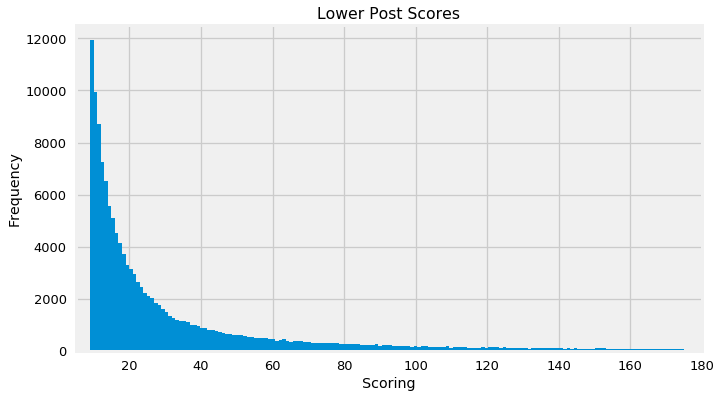

In [5]:
# Create the correct bin size
bins, lower, upper = binSize(lower=0, upper=175)

# Plot distribution of lower scores
tmp = df[[ True if lower <= x <= upper else False for x in df['score'] ]]['score']
plotHist(tmp=tmp, bins=bins, title='Lower Post Scores', xlabel='Scoring', ylabel='Frequency', l=5, u=5);

Lower Bound: 0
Upper Bound: 300

Local Max Lengths: 343
Local Average Lengths: 58
Local Median Lengths: 49


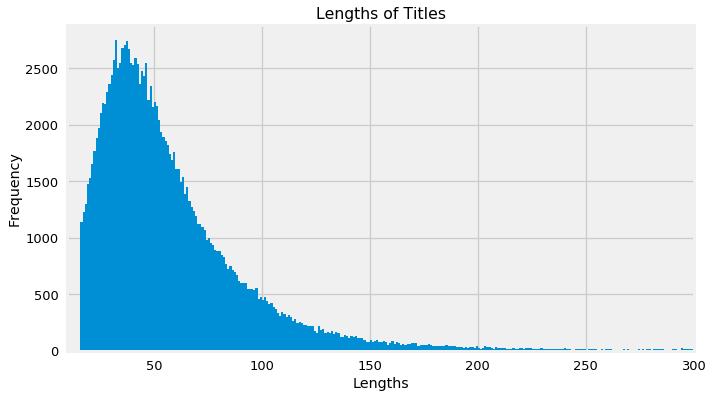

In [7]:
# Titles should be less than 300 charcters 
# Outliers are due to unicode translation
# Plot lengths of titles
tmp = [ len(x) for x in df.title ]
bins, lower, upper = binSize(lower=0, upper=300, buffer=-.09)

plotHist(tmp=tmp, bins=bins, title='Lengths of Titles', xlabel='Length', ylabel='Frequency', l=10, u=0);

Lower Bound: 500
Upper Bound: 5000

Local Max Lengths: 5000
Local Average Lengths: 1479
Local Median Lengths: 1128


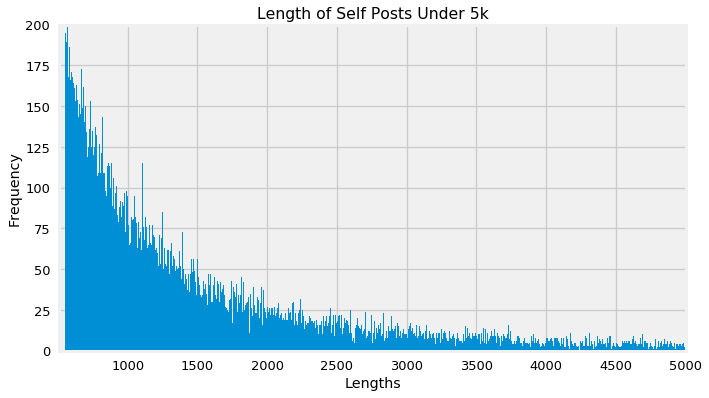

In [8]:
# Slice lengths of texts and plot histogram
bins, lower, upper = binSize(lower=500, upper=5000, buffer=.011)
tmp = [len(x) for x in df.selftext if lower <= len(x) <= upper]

plotHist(tmp=tmp, bins=bins, title='Length of Self Posts Under 5k', xlabel='Length', ylabel='Frequency', l=10, u=0)
plt.ylim(0, 200);

# Anomalies could be attributed to bots or duplicate reposts

Subreddits: 8497
Total Posts: 146996
Total Posts from Top 100: 47498 , 0.323 of Total
Total Posts from Top 10: 13683 , 0.093 of Total

Top 10 Contributors: subreddit
noveltranslations      2583
The_Donald             2241
relationships          2129
JUSTNOMIL              1136
exmormon               1065
raisedbynarcissists    1015
asoiaf                  924
Overwatch               870
legaladvice             869
nosleep                 851
Name: id, dtype: int64


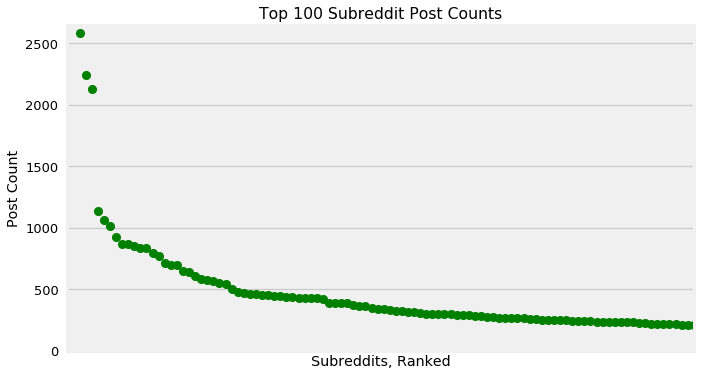

In [5]:
# Posts per Subreddit
tmp = df.groupby('subreddit')['id'].nunique().sort_values(ascending=False)
top = 100
s = sum(tmp)
print('Subreddits:', len(tmp))
print('Total Posts:', s)
print('Total Posts from Top %s:' % top, sum(tmp[:top]), ', %.3f of Total' % (sum(tmp[:top])/s))
print('Total Posts from Top 10:', sum(tmp[:10]), ', %.3f of Total' % (sum(tmp[:10])/s))
print('\nTop 10 Contributors:', tmp[:10])



plt.figure(figsize=(10,6))
plt.plot(tmp, 'go')
plt.xticks('')
plt.title('Top %s Subreddit Post Counts' % top)
plt.xlabel('Subreddits, Ranked')
plt.ylabel('Post Count')    
plt.xlim(-2, top+1)
plt.ylim(0, 2650);

In [5]:
path1 = 'data/origin.pkl'
#path2 = 'data/grouped.pkl'

# Save important data
origin_df = df.loc[:,['created_utc', 'subreddit', 'author', 'title', 'selftext', 'id']] \
              .copy().reset_index().rename(columns={"index": "position"})
print(origin_df.info())
origin_df.to_pickle(path1)

posts_df = origin_df.loc[:,['title', 'selftext']]
posts_df['text'] = posts_df.title + ' ' + df.selftext
#del origin_df

# To group the results later
def groupUserPosts(x):
    ''' Group users' id's by post '''
    return pd.Series(dict(ids = ", ".join(x['id']),                    
                          text = ", ".join(x['text'])))

###df = posts_df.groupby('author').apply(groupUserPosts) 
#df.to_pickle(path2)

df = posts_df.text.to_frame()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146996 entries, 0 to 146995
Data columns (total 7 columns):
position       146996 non-null int64
created_utc    146996 non-null int64
subreddit      146996 non-null object
author         146996 non-null object
title          146996 non-null object
selftext       146996 non-null object
id             146996 non-null object
dtypes: int64(2), object(5)
memory usage: 7.9+ MB
None


In [8]:
origin_df.sample(2).drop('author', axis=1)

position  created_utc         subreddit  \
87215     87215   1466290034  ApocalypseRising   
10192     10192   1466708919              Rift   

                                                                                  title  \
87215  Pride Squad vs Oblivion Squad / ARCL Season 2 / Post-Match Discussion (Spoilers)   
10192                                                      Steam Sale, 25% off RIFT DLC   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       selftext  \
87215                                                                                                                                                         **Pride Squad 2-5 Oblivion Squad**\n\n-----\n\n[Pride Squad Roblox Group](https://www.roblox.com/Groups/Group.aspx?gid=2771273)\n\n[Oblivion Squad Roblox Group](https://www.roblox.com/Groups/Group.aspx?gid=2616502)\n\n-----\n\n[Squad Battle Footage](https://www.twitch.tv/dualpointtv/v/73213805)\n\n[Challonge Bracket](http://arcl.challonge.com/S2)\n\n-----\n\n**Map:** Vernal-Mason\n\nPride Squad | Kills | Died?\n---------| ---------| ---------|\nAmaniLewis | 1 | Yes\nAnchoredPart | 0 | Yes\nUltify | 0 | Yes\nRezify | 0 | Yes\nPractors | 1 | Yes\n\nOblivion Squad | Kills | Died?\n---------| ---------| ---------|\nSxndJ | 0 | Yes\nBenefix | 0 | No\nVryxe | 1 | No\nFex | 4 | No\nAvoxity | 0 | Yes\n\n   
10192  If you head to the [RIFT page on Steam](http://store.steampowered.com/app/39120/) now through July 4th, you will find 25% off all RIFT DLCs:\n\n* RIFT - Ascended Soul DLC $26.24\n* RIFT: Storm Legion Pack $22.49 \n* RIFT: Nightmare Tide Pack $44.99\n* RIFT: Planetouched Wilds Pack $59.99\n* RIFT: Ultimate RIFT Edition $112.49\n\n### Do I need to play through Steam to use this?\n\nNo, but you will need a Steam account and the Steam client.  Once you do, buy the DLC. *Start* the download in Steam, then right-click the game and click View CD Keys.  Copy your new key then you can stop the Steam download.  Log in at https://rift.trionworlds.com/ then under Apply Code, click Learn More, and apply your code.  You may need to also exit RIFT and Glyph then re-log in.  \nAlso, you can wait to see if Amazon or Trion match the prices during the Steam sale.   

           id  
87215  4oqpb8  
10192  4pignv

In [6]:
%%time
def clean_text(df, text_field):
    '''
    Clean all the text data within a certain text column of the dataFrame.
    '''
    df[text_field] = df[text_field].str.replace(r"http\S+", " ")
    df[text_field] = df[text_field].str.replace(r"&[a-z]{2,4};", "")
    df[text_field] = df[text_field].str.replace("\\n", " ")
    df[text_field] = df[text_field].str.replace(r"#f", "")
    df[text_field] = df[text_field].str.replace(r"[\’\'\`\":]", "")
    df[text_field] = df[text_field].str.replace(r"[^A-Za-z0-9]", " ")
    df[text_field] = df[text_field].str.replace(r" +", " ")
    df[text_field] = df[text_field].str.lower()
    
clean_text(df, 'text')

CPU times: user 42.8 s, sys: 564 ms, total: 43.3 s
Wall time: 43.4 s


In [31]:
df.sample(3)

text
132875                                                                                                                                                                                       fanart saekano support katou megumi album just a small compilation album of katou megumi by various artists anime saenai heroine no sodatekata number of pics 84 some of the pics are slightly nsfw but nothing too extreme also found a full color hentai doujin featuring katou but that ones too nsfw to post here can send you the link by pm if youre interested edit2 seeding over will keep giving the doujin for those that want it just pm me if ive missed anyone will try to bring more katou goods soon also remember to support megumi on todays best girl voting contest lets help her become the heroine that will tug at everyones heart vote megumi here edit for those new to the series and that wish to know more about our candidate heroine heres the katou appreciation thread make r anime great again vote katou megumi 
8756    is a toyota mk2 mr2 a good first car ive recently fallen in love with the mr2 and ive been planning to try and buy one in the summer since i will be working a lot this is going to be my first car but i want something that i think is attractive and somewhat quick and that i can work on this car seems to fit all of those categories for me i am prepared to work on one in fact i actually want to and have a few friends that would help me out i guess i was just wondering if there are any downsides to the car that should deter me from getting it edit revised post edit 2 im going to be 18 this year edit 3 thanks for all of the responses both funny and serious i am learning a lot about the car and am still considering it but to be clear i already considered a miata but i just dont like the feel of it as ive sat in one before and i dont know what it was but i wasnt really feeling it please feel free to keep leaving responses i am reading everyones posts as i find them very informative and f...
101054                                                                                                                                                                                                                                         daily discussion thursday june 02 2016 welcome to the r bitcoinmarkets daily discussion thread thread topics include but are not limited to general discussion related to the days events technical analysis trading ideas strategies questions that do not warrant a separate post thread guidelines be excellent to each other please do not create separate posts for the types of discussion mentioned above outside of the daily thread if you do your post may be removed and or heavily downvoted news that may have a big impact on the market may be posted as a separate thread other ways to interact live chat on bitcoinmarkets irc set your flair to participate in the bitcoinmarkets flair game view current standings weekly threads moronic mondays and fundamentals fridays

In [9]:
# For exploration of users
df[origin_df.author == '<Redacted>'][:3]

# User is a post summarizer and aggregator, added /r/tldr to the blocked list!

text
12537   friday  june 17th  a british mp has been killed  a 3d printed self driving minibus is about to hit the road in the us  and guardians of the galaxy 2 wraps production     r worldnews    u nothematic posts that  british labour mp jo cox has died after being shot and stabbed         r news    u tehgerbil posts that  the parents of a 12 year old black girl have sued her school after a group of white classmates allegedly wrapped a rope around her neck and jerked her to the ground         r technology    u scitech9000 tells us  a 3d printed self driving minibus is about to hit the road in the us         r futurology    u albaniankalle tells us  finland is a future obsessed nation         r politics    u foxn4wsreddit shares that  the dnc wanted clinton from the start         r todayilearned    u papasangiorgio learns that  the company who made settlers of catan made a real cones of dunshire game  after the fictional game ben wyatt made up in parks and recreation         r iama    a gro...
12538   thursday  june 16th  germany will end its unofficial tolerance of polygamy  spacexs falcon 9 rocket has exploded  and scientists have detected gravitational waves again     r worldnews    u maxwellhill posts that  germany will end its unofficial tolerance of polygamy         r news    u craigjclark68 posts that  us law enforcement officials have said american muslims have repeatedly informed authorities about fellow muslims they fear might be turning to extremism         r science    u drewiepoodle shares that  a neurosurgeon has used ultrasound to open the blood brain barrier in patients with recurrent glioblastoma         r technology    u gurumeditationerror shares that  spacexs falcon 9 rocket has exploded         r todayilearned    u laanai 98 learns about  a pig who saved her owners life         r askreddit     u iwillnottalktou asks about  statements that make us roll our eyes immediately         r askscience    u kingkiller 123 wants to know  why it is that when a number ...
12539   saturday  june 25th  global stock markets lose  2 1 trillion after brexit  nasa approves 5 more years for the hubble space telescope  and bernie worrell has died at age 72     r worldnews    u grepnork posts that  global stock markets have lost  2 1 trillion after brexit         r news    u madazzahatter posts that  valve  the company behind csgo  is being sued for its role in the multi billion dollar gambling economy that has fueled the games popularity         r technology    u jackson barteno tells us  nasa has approved 5 more years for the hubble space telescope         r politics    u jimrosenz tells us  clinton and trump are both liars         r todayilearned    u theemeraldmoose learns that  3 fungi species were found near the chernobyl nuclear power plant that appear to convert gamma radiation into chemical energy         r iama    singer songwriter hozier invites us to ask him anything         r askreddit    u spac3noodl3 asks about  parts of reddit culture that annoy us...

Lower Bound: 500
Upper Bound: 5000

Local Max Lengths: 5000
Local Average Lengths: 1531
Local Median Lengths: 1185


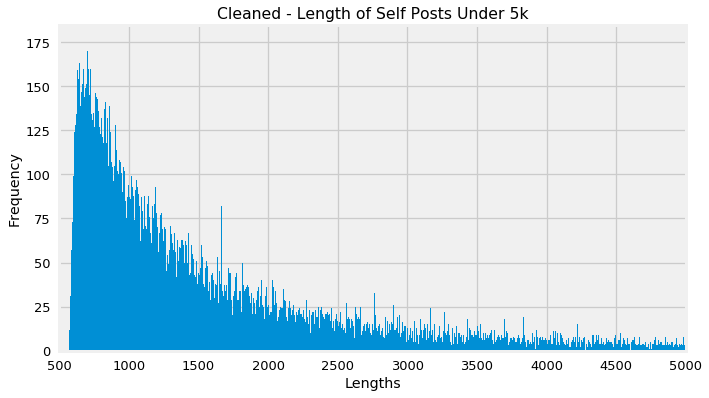

In [20]:
# Slice lengths of texts and plot histogram
bins, lower, upper = binSize(lower=500, upper=5000, buffer=.015)
tmp = [len(x) for x in df.text if lower <= len(x) <= upper]

plotHist(tmp=tmp, bins=bins, title='Cleaned - Length of Self Posts Under 5k', 
         xlabel='Lengths', ylabel='Frequency', l=0, u=0)
plt.ylim(0, 185);

In [5]:
# Download everything for nltk! ('all')
import nltk
nltk.download() # (Change config save path)
nltk.data.path.append('/home/User/data/')

NLTK Downloader
---------------------------------------------------------------------------
    d) Download   l) List    u) Update   c) Config   h) Help   q) Quit
---------------------------------------------------------------------------
Downloader> c

Data Server:
  - URL: <https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml>
  - 7 Package Collections Available
  - 106 Individual Packages Available

Local Machine:
  - Data directory: /home/Dave/nltk_data

---------------------------------------------------------------------------
    s) Show Config   u) Set Server URL   d) Set Data Dir   m) Main Menu
---------------------------------------------------------------------------
Config> d
  New Directory> /home/Dave/data

---------------------------------------------------------------------------
    s) Show Config   u) Set Server URL   d) Set Data Dir   m) Main Menu
---------------------------------------------------------------------------
Config> m

-------------------

In [6]:
from nltk.corpus import stopwords

# "stopeng" is our extended list of stopwords for use in the CountVectorizer
# I could spend days extending this list for fine tuning results
stopeng = stopwords.words('english')
stopeng.extend([x.replace("\'", "") for x in stopeng])
stopeng.extend(['nbsp', 'also', 'really', 'ive', 'even', 'jon', 'lot', 'could', 'many'])
stopeng = list(set(stopeng))

In [10]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Count vectorization for LDA
cv = CountVectorizer(token_pattern='\\w{3,}', max_df=.30, min_df=.0001, 
                     stop_words=stopeng, ngram_range=(1,1), lowercase=False,
                     dtype='uint8')

# Vectorizer object to generate term frequency-inverse document frequency matrix
tfidf = TfidfVectorizer(token_pattern='\\w{3,}', max_df=.30, min_df=.0001, 
                        stop_words=stopeng, ngram_range=(1,1), lowercase=False,
                        sublinear_tf=True, smooth_idf=False, dtype='float32')

###### Tokenization is one of the most important steps in NLP, I will explain some of my parameter choices in the README. CountVectorizer was my preferred choice. I used these definitions to help me in the iterative process of building an unsupervised model.

###### The goal of using tf-idf instead of the raw frequencies of occurrence of a token in a given document is to scale down the impact of tokens that occur very frequently in a given corpus and that are hence empirically less informative than features that occur in a small fraction of the training corpus.

###### Smooth = False: The effect of adding “1” to the idf in the equation above is that terms with zero idf, i.e., terms that occur in all documents in a training set, will not be entirely ignored.

###### sublinear_tf = True: “l” (logarithmic), replaces tf with 1 + log(tf)

In [11]:
%%time
# Count & tf-idf vectorizer fits the tokenizer and transforms data into new matrix
cv_vecs = cv.fit_transform(df.text).transpose()
tf_vecs = tfidf.fit_transform(df.text).transpose()
pickle.dump(cv_vecs, open('data/cv_vecs.pkl', 'wb'))

# Checking the shape and size of the count vectorizer transformed matrix
# 47,317 terms
# 146996 documents
print("Sparse Shape:", cv_vecs.shape) 
print('CV:', sys.getsizeof(cv_vecs))
print('Tf-Idf:', sys.getsizeof(tf_vecs))

Sparse Shape: (47317, 146996)
CV: 56
Tf-Idf: 56
CPU times: user 1min 22s, sys: 1.79 s, total: 1min 24s
Wall time: 1min 24s


In [14]:
# IFF using a subset can you store these in a Pandas DataFrame/

#tfidf_df = pd.DataFrame(tf_vecs.transpose().todense(), columns=[tfidf.get_feature_names()]).astype('float32')
#cv_df = pd.DataFrame(cv_vecs.transpose().todense(), columns=[cv.get_feature_names()]).astype('uint8')

#print(cv_df.info())
#print(tfidf_df.info())

In [15]:
#cv_description = cv_df.describe().T
#tfidf_description = tfidf_df.describe().T

#tfidf_df.sum().sort_values(ascending=False)

In [71]:
# Explore the document-term vectors
#cv_description.sort_values(by='max', ascending=False)
#tfidf_description.sort_values(by='mean', ascending=False)

count    mean     std     min     25%     50%  \
de                    10000.00000 0.03340 1.08416 0.00000 0.00000 0.00000   
comment               10000.00000 0.03200 1.17597 0.00000 0.00000 0.00000   
2017                  10000.00000 0.05470 0.90188 0.00000 0.00000 0.00000   
box                   10000.00000 0.02900 0.77783 0.00000 0.00000 0.00000   
videos                10000.00000 0.02830 0.80347 0.00000 0.00000 0.00000   
point                 10000.00000 0.07840 0.79014 0.00000 0.00000 0.00000   
la                    10000.00000 0.01890 0.69296 0.00000 0.00000 0.00000   
fc                    10000.00000 0.00910 0.62374 0.00000 0.00000 0.00000   
12                    10000.00000 0.06470 0.82522 0.00000 0.00000 0.00000   
nbsp                  10000.00000 0.03170 0.95467 0.00000 0.00000 0.00000   
17                    10000.00000 0.03780 0.67410 0.00000 0.00000 0.00000   
clinched              10000.00000 0.00550 0.54009 0.00000 0.00000 0.00000   
wilt                  10000.00000 0.00560 0.53028 0.00000 0.00000 0.00000   
dog                   10000.00000 0.05610 1.04416 0.00000 0.00000 0.00000   
un                    10000.00000 0.01010 0.52690 0.00000 0.00000 0.00000   
100                   10000.00000 0.03460 0.55266 0.00000 0.00000 0.00000   
million               10000.00000 0.01130 0.51303 0.00000 0.00000 0.00000   
scp                   10000.00000 0.00670 0.49425 0.00000 0.00000 0.00000   
et                    10000.00000 0.01020 0.50628 0.00000 0.00000 0.00000   
common                10000.00000 0.01950 0.48181 0.00000 0.00000 0.00000   
xxxx                  10000.00000 0.00480 0.45055 0.00000 0.00000 0.00000   
captain               10000.00000 0.00770 0.44951 0.00000 0.00000 0.00000   
group                 10000.00000 0.04290 0.51970 0.00000 0.00000 0.00000   
day                   10000.00000 0.12960 0.66622 0.00000 0.00000 0.00000   
boxes                 10000.00000 0.00830 0.42994 0.00000 0.00000 0.00000   
added                 10000.00000 0.01840 0.44258 0.00000 0.00000 0.00000   
points                10000.00000 0.03140 0.53333 0.00000 0.00000 0.00000   
united                10000.00000 0.01020 0.44375 0.00000 0.00000 0.00000   
auburn                10000.00000 0.00510 0.40236 0.00000 0.00000 0.00000   
humanity              10000.00000 0.00650 0.40531 0.00000 0.00000 0.00000   
got                   10000.00000 0.16930 0.66173 0.00000 0.00000 0.00000   
season                10000.00000 0.04620 0.61879 0.00000 0.00000 0.00000   
le                    10000.00000 0.00730 0.41769 0.00000 0.00000 0.00000   
hfy                   10000.00000 0.00400 0.39013 0.00000 0.00000 0.00000   
2016                  10000.00000 0.02020 0.57221 0.00000 0.00000 0.00000   
board                 10000.00000 0.01330 0.41127 0.00000 0.00000 0.00000   
wiki                  10000.00000 0.01170 0.39595 0.00000 0.00000 0.00000   
bon                   10000.00000 0.00440 0.37228 0.00000 0.00000 0.00000   
nodes                 10000.00000 0.00590 0.36889 0.00000 0.00000 0.00000   
heroes                10000.00000 0.00840 0.38307 0.00000 0.00000 0.00000   
authors               10000.00000 0.00380 0.36028 0.00000 0.00000 0.00000   
node                  10000.00000 0.00780 0.37809 0.00000 0.00000 0.00000   
mil                   10000.00000 0.00530 0.35424 0.00000 0.00000 0.00000   
ppg                   10000.00000 0.00500 0.34697 0.00000 0.00000 0.00000   
mother                10000.00000 0.01680 0.41320 0.00000 0.00000 0.00000   
dad                   10000.00000 0.01760 0.39712 0.00000 0.00000 0.00000   
subject               10000.00000 0.01100 0.34999 0.00000 0.00000 0.00000   
drugs                 10000.00000 0.01750 0.41062 0.00000 0.00000 0.00000   
game                  10000.00000 0.22850 0.99498 0.00000 0.00000 0.00000   
qui                   10000.00000 0.00400 0.32279 0.00000 0.00000 0.00000   
state                 10000.00000 0.04500 0.64716 0.00000 0.00000 0.00000   
sayori                10

## <a id='svd'></a>Singular Value Decomposition (SVD)

In [ ]:
#from sklearn.utils.extmath import randomized_svd

# Randomized SVD for extracting the full decomposition
#U, Sigma, VT = randomized_svd(tf_vecs, n_components=8, random_state=42)

In [11]:
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer

def Trunc_SVD(vectorized, n_components=300, iterations=1, normalize=False, random_state=42):
    """
    Performs LSA/LSI on a sparse document term matrix, returns a fitted, transformed, (normalized) LSA object
    """
    # Already own the vectorized data for LSA, just transpose it back to normal
    vecs_lsa = vectorized.T

    # Initialize SVD object as LSA
    lsa = TruncatedSVD(n_components=n_components, n_iter=iterations, algorithm='randomized', random_state=random_state)
    dtm_lsa = lsa.fit(vecs_lsa)
    print("Explained Variance - LSA {}:".format(n_components), dtm_lsa.explained_variance_ratio_.sum())
    if normalize:
        dtm_lsa_t = lsa.fit_transform(vecs_lsa)
        dtm_lsa_t = Normalizer(copy=False).fit_transform(dtm_lsa_t)
        return dtm_lsa, dtm_lsa_t
    return dtm_lsa


def plot_SVD(lsa, title, level=None):
    """
    Plots the singular values of an LSA object
    """
    plt.figure(num=1, figsize=(15,10))
    plt.suptitle(title, fontsize=22, x=.55, y=.45, horizontalalignment='left')
    plt.subplot(221)
    plt.title('Explained Variance by each Singular Value')
    plt.plot(lsa.explained_variance_[:level])
    
    plt.subplot(222)
    plt.title('Explained Variance Ratio by each Singular Value')
    plt.plot(lsa.explained_variance_ratio_[:level])
    
    plt.subplot(223)
    plt.title("Singular Values ('Components')")
    plt.plot(lsa.singular_values_[:level])
    plt.show()

Explained Variance - LSA 350: 0.4865536129677702


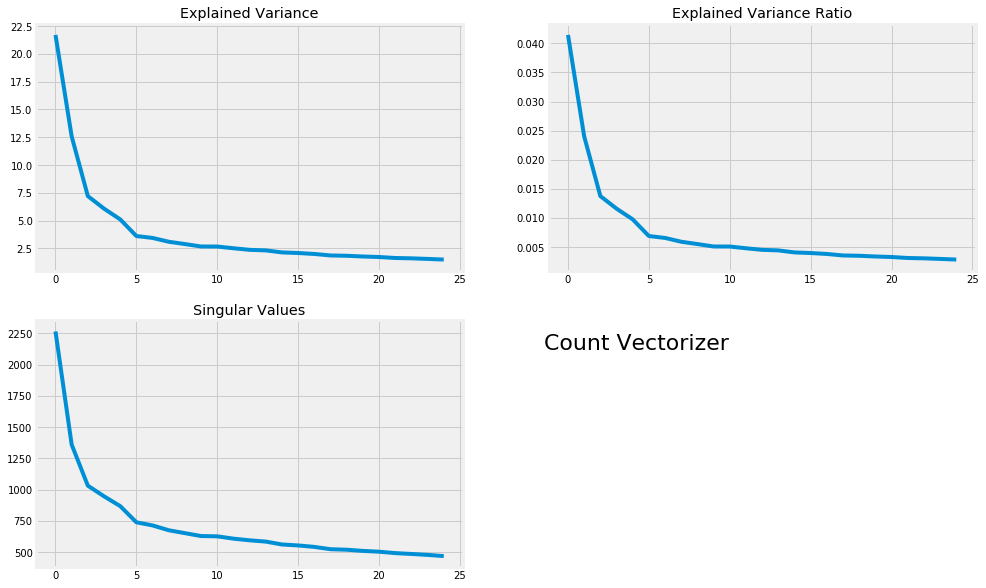

Explained Variance - LSA 350: 0.16077128845553074


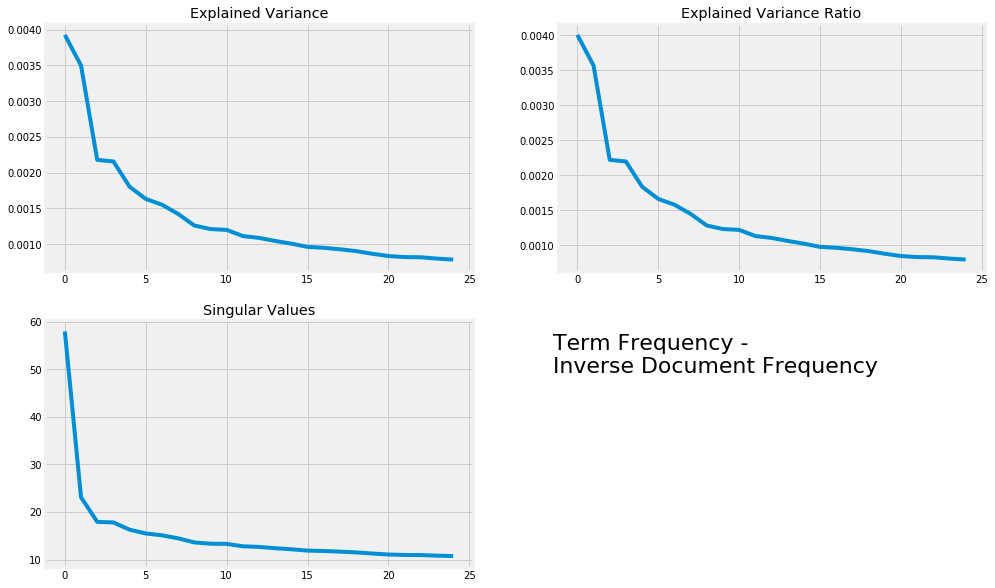

CPU times: user 7min 53s, sys: 3min 9s, total: 11min 2s
Wall time: 5min 42s


In [18]:
%%time
components = 350
cv_dtm_lsa = Trunc_SVD(cv_vecs, n_components=components, iterations=5, normalize=False)
plot_SVD(cv_dtm_lsa, title='Count Vectorizer', level=25)

tf_dtm_lsa = Trunc_SVD(tf_vecs, n_components=components, iterations=5, normalize=False)
plot_SVD(tf_dtm_lsa, title='Term Frequency - \nInverse Document Frequency', level=25)

In [26]:
# Numerically confirming the elbow in the above plot
print('SVD Value| CV | TFIDF')
print('Top 2:  ',round(sum(list(cv_dtm_lsa.explained_variance_ratio_[:2])),3),round(sum(list(tf_dtm_lsa.explained_variance_ratio_[:2])),3))
print('Top 3:  ',round(sum(list(cv_dtm_lsa.explained_variance_ratio_[:3])),3),round(sum(list(tf_dtm_lsa.explained_variance_ratio_[:3])),3))
print('Top 4:  ',round(sum(list(cv_dtm_lsa.explained_variance_ratio_[:4])),3),round(sum(list(tf_dtm_lsa.explained_variance_ratio_[:4])),3))
print('Top 5:  ',round(sum(list(cv_dtm_lsa.explained_variance_ratio_[:5])),3),round(sum(list(tf_dtm_lsa.explained_variance_ratio_[:5])),3))
print('Top 6:  ',round(sum(list(cv_dtm_lsa.explained_variance_ratio_[:6])),3),round(sum(list(tf_dtm_lsa.explained_variance_ratio_[:6])),3))
print('Top 7:  ',round(sum(list(cv_dtm_lsa.explained_variance_ratio_[:7])),3),round(sum(list(tf_dtm_lsa.explained_variance_ratio_[:7])),3))
print('Top 8:  ',round(sum(list(cv_dtm_lsa.explained_variance_ratio_[:8])),3),round(sum(list(tf_dtm_lsa.explained_variance_ratio_[:8])),3))
print('Top 16:\t',round(sum(list(cv_dtm_lsa.explained_variance_ratio_[:16])),3),round(sum(list(tf_dtm_lsa.explained_variance_ratio_[:16])),3))
print('Top 32:\t',round(sum(list(cv_dtm_lsa.explained_variance_ratio_[:32])),3),round(sum(list(tf_dtm_lsa.explained_variance_ratio_[:32])),3))
print('Top 64:\t',round(sum(list(cv_dtm_lsa.explained_variance_ratio_[:64])),3),round(sum(list(tf_dtm_lsa.explained_variance_ratio_[:64])),3))
print('Top 128:',round(sum(list(cv_dtm_lsa.explained_variance_ratio_[:128])),3),round(sum(list(tf_dtm_lsa.explained_variance_ratio_[:128])),3))
print('Top 256:',round(sum(list(cv_dtm_lsa.explained_variance_ratio_[:256])),3),round(sum(list(tf_dtm_lsa.explained_variance_ratio_[:256])),3))
print('Top 350:',round(sum(list(cv_dtm_lsa.explained_variance_ratio_[:350])),3),round(sum(list(tf_dtm_lsa.explained_variance_ratio_[:350])),3))

SVD Value| CV | TFIDF
Top 2:   0.065 0.008
Top 3:   0.079 0.01
Top 4:   0.091 0.012
Top 5:   0.101 0.014
Top 6:   0.107 0.015
Top 7:   0.114 0.017
Top 8:   0.12 0.019
Top 16:	 0.157 0.028
Top 32:	 0.205 0.041
Top 64:	 0.265 0.059
Top 128: 0.342 0.088
Top 256: 0.439 0.134
Top 350: 0.487 0.161


Explained Variance Ratio (EVR):
 [0.04145 0.02402 0.01375 0.01160 0.00975 0.00689 0.00656 0.00591 0.00551
 0.00509 0.00508 0.00479 0.00452 0.00442 0.00407 0.00397 0.00381 0.00355
 0.00350 0.00337]
Difference in EVR (start 3):
 [-0.00216 -0.00185 -0.00286 -0.00033 -0.00066 -0.00040 -0.00042 -0.00001
 -0.00030 -0.00027 -0.00009 -0.00035 -0.00010 -0.00016 -0.00026 -0.00005
 -0.00012]


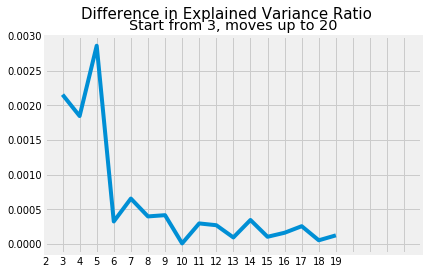

In [82]:
# Close look at the elbow plots
def elbow(dtm_lsa):
    evr = dtm_lsa.explained_variance_ratio_[:20]
    print("Explained Variance Ratio (EVR):\n", evr)
    print("Difference in EVR (start 3):\n", np.diff(evr[2:]))
    plt.figure()
    plt.plot(-np.diff(evr[2:]))
    plt.xticks(range(-1,22), range(2,20))
    plt.suptitle('Difference in Explained Variance Ratio', fontsize=15);
    plt.title('Start from 3, moves up to 20');

# Count Vectorizer
elbow(cv_dtm_lsa)

Explained Variance Ratio (EVR):
 [0.00400 0.00357 0.00222 0.00220 0.00184 0.00166 0.00158 0.00145 0.00128
 0.00123 0.00122 0.00113 0.00111 0.00106 0.00103 0.00098 0.00097 0.00095
 0.00092 0.00088]
Difference in EVR (start 3):
 [-0.00002 -0.00036 -0.00017 -0.00008 -0.00013 -0.00017 -0.00005 -0.00001
 -0.00009 -0.00003 -0.00004 -0.00004 -0.00005 -0.00001 -0.00002 -0.00003
 -0.00004]


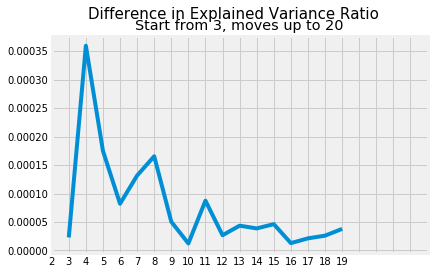

In [83]:
# Tf-Idf
elbow(tf_dtm_lsa)

###### The count vectorizer seems like it will be more fool proof, so I will use cv for my study. 8 might be a good cutoff value for the number of components kept in dimensionality reduction, I will try to confirm this later with KMeans clustering. The intuition behind this is that the slope after the 8th element is significantly different from the first elements. Keeping just 2 components would not be sufficient enough for clustering because we want to retain as much information as we can while still cutting down the dimensions to find some kind of human readable latent concept space.

###### I am going to try out 2 quick methods before clustering and moving onto my main goal of topic modeling with LDA.

## <a id='lsa'></a> Latent Semantic Analysis (LSA)

In [12]:
%%time
from gensim import corpora, matutils, models

# Convert sparse matrix of term-doc counts to a gensim corpus
cv_corpus = matutils.Sparse2Corpus(cv_vecs)
pickle.dump(cv_corpus, open('data/cv_corpus.pkl', 'wb'))

# Maps index to term
id2word = dict((v, k) for k, v in cv.vocabulary_.items())

# This is for Python 3, Need this for something at the end
id2word = corpora.Dictionary.from_corpus(cv_corpus, id2word=id2word)
pickle.dump(lda, open('data/id2word.pkl', 'wb'))

# Fitting an LSI model
lsi = models.LsiModel(corpus=cv_corpus, id2word=id2word, num_topics=10)

2018-03-11 18:22:19,137 : INFO : 'pattern' package not found; tag filters are not available for English
2018-03-11 18:22:19,167 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2018-03-11 18:22:20,327 : INFO : adding document #10000 to Dictionary(0 unique tokens: [])
2018-03-11 18:22:21,548 : INFO : adding document #20000 to Dictionary(0 unique tokens: [])
2018-03-11 18:22:22,807 : INFO : adding document #30000 to Dictionary(0 unique tokens: [])
2018-03-11 18:22:24,019 : INFO : adding document #40000 to Dictionary(0 unique tokens: [])
2018-03-11 18:22:25,235 : INFO : adding document #50000 to Dictionary(0 unique tokens: [])
2018-03-11 18:22:26,512 : INFO : adding document #60000 to Dictionary(0 unique tokens: [])
2018-03-11 18:22:27,745 : INFO : adding document #70000 to Dictionary(0 unique tokens: [])
2018-03-11 18:22:29,009 : INFO : adding document #80000 to Dictionary(0 unique tokens: [])
2018-03-11 18:22:30,274 : INFO : adding document #90000 to Dictionary(0 unique to

2018-03-11 18:23:01,946 : INFO : topic #2(776.496): 0.498*"game" + 0.276*"damage" + 0.212*"team" + -0.170*"said" + -0.142*"back" + 0.123*"picks" + 0.120*"bans" + 0.114*"play" + 0.102*"start" + 0.093*"players"
2018-03-11 18:23:01,948 : INFO : topic #3(680.769): 0.449*"damage" + -0.382*"game" + -0.177*"picks" + 0.176*"deal" + -0.176*"bans" + 0.153*"chance" + 0.152*"seconds" + 0.141*"dmg" + 0.134*"blk" + 0.128*"target"
2018-03-11 18:23:01,950 : INFO : topic #4(549.922): -0.438*"bans" + -0.435*"picks" + -0.248*"start" + -0.232*"highlights" + 0.221*"que" + -0.206*"spoilers" + -0.124*"youtube" + -0.111*"said" + 0.093*"los" + 0.090*"season"
2018-03-11 18:23:02,713 : INFO : preparing a new chunk of documents
2018-03-11 18:23:03,518 : INFO : using 100 extra samples and 2 power iterations
2018-03-11 18:23:03,519 : INFO : 1st phase: constructing (47317, 110) action matrix
2018-03-11 18:23:04,208 : INFO : orthonormalizing (47317, 110) action matrix
2018-03-11 18:23:07,648 : INFO : 2nd phase: runni

CPU times: user 1min 58s, sys: 60 s, total: 2min 58s
Wall time: 1min 4s


In [13]:
%%time
# Retrieve vectors for the original cv corpus in the LS space ("transform" in sklearn)
lsi_corpus = lsi[cv_corpus]

# Dump the resulting document vectors into a list
doc_vecs = [doc for doc in lsi_corpus]

CPU times: user 16.1 s, sys: 1.35 s, total: 17.4 s
Wall time: 17.4 s


In [27]:
doc_vecs[0][:5]

[(0, 1.9446177766541766),
 (1, -2.4106649569930907),
 (2, 1.2682259525175852),
 (3, 2.1424905719310936),
 (4, -1.4078167012796912)]

In [28]:
# Sum of a documents' topics (?)
for i in range(5):
    print(sum(doc_vecs[i][1]))

-1.4106649569930907
-0.031444038368904303
-1.2723604749491777
0.15042521472269477
0.690384834127101


## <a id='sim'></a> Similarity Scoring

In [43]:
from gensim import similarities

# Create an index transformer that calculates similarity based on our space
index = similarities.MatrixSimilarity(doc_vecs, num_features=300)

# Return the sorted list of cosine similarities to the docu document
docu = 5 # Change docu as needed
sims = sorted(enumerate(index[doc_vecs[docu]]), key=lambda item: -item[1])
np.r_[sims[:10] , sims[-10:]]

2018-03-11 06:05:35,806 : INFO : creating matrix with 146996 documents and 300 features


array([[5.0000, 1.0000],
       [30657.0000, 0.9876],
       [22319.0000, 0.9860],
       [8091.0000, 0.9858],
       [113679.0000, 0.9856],
       [26449.0000, 0.9843],
       [107391.0000, 0.9841],
       [120944.0000, 0.9837],
       [128853.0000, 0.9836],
       [24683.0000, 0.9836],
       [137752.0000, -0],
       [8740.0000, -0],
       [20137.0000, -0],
       [135470.0000, -0],
       [131917.0000, -0],
       [145455.0000, -0],
       [61673.0000, -0],
       [38001.0000, -0],
       [8408.0000, -0],
       [126462.0000, -0]])

In [46]:
# Viewing similarity of top documents
top = 1
for sim_doc_id, sim_score in sims[:top + 1]: 
    print("\nScore:", sim_score)
    print("Document Text:\n", df.text[sim_doc_id])


Score: 0.99999994
Document Text:
 I just recharged the A/C on my 2008 328xi Just wanted to share my success story.

This was an extremely easy project, after about 10 minutes of research.

The most difficult part was knowing which knob was the low-pressure service knob. After I convinced myself I had it right, the entire thing was smooth sailing.

I was a little disappointed about the lack of specific directions on the interwebs, but there was enough for me to complete this successfully.

I had NO cold air at all. The entire thing just blew hot air with all the recommended settings. Since it's now 103 degrees here in Boulder, CO, I figured it was time.

I bought the hose/gauge and can of refrigerant at an o'reilly's auto parts store. 

Here are the steps I took to check the pressure of the system:

DISCLAIMER: I know very little about engine systems. However, I do have a little bit of gumption and a can-do attitude.

1. Let car run for 3 minutes with A/C at max, with recycled air sett

###### The metrics look artifically high, and do not match well for each document. The similarity method could be used to optimize keyword search if we were trying to expand the reach of a certain demographic using these rankings. The next step would be to improve on this method with word2vec or a better LSI model.

# <a id='km'></a>KMeans Clustering

In [49]:
lsi_red = matutils.corpus2dense(lsi_corpus, num_terms=300).transpose()
print('Reduced LS space shape:', lsi_red.shape)
print('Reduced LS space size in bytes:', sys.getsizeof(lsi_red))

# Taking a subset for Kmeans due to memory dropout
lsi_red_sub = lsi_red.copy()
np.random.shuffle(lsi_red_sub)
lsi_red_sub = lsi_red_sub[:30000]
lsi_red_sub = Normalizer(copy=False).fit_transform(lsi_red_sub) # Normalized for the Euclidean metric
print('Reduced LS space subset shape:', lsi_red_sub.shape)
print('Reduced LS space subset size in bytes:', sys.getsizeof(lsi_red_sub))

Reduced LS space shape: (146996, 300)
Reduced LS space size in bytes: 112
Reduced LS space subset shape: (30000, 300)
Reduced LS space subset size in bytes: 112


In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Calculating Silhouette coefficients and Sum of Squared Errors
def silhouette_co(start, stop, lsi_red_sub, random_state=42, n_jobs=-2, verbose=4):
    """ 
    Input a normalized subset of a reduced dense latent semantic matrix
    Returns list of scores for plotting
    """
    SSEs = []
    Sil_coefs = []
    try_clusters = range(start, stop)
    for k in try_clusters:
        km = KMeans(n_clusters=k, random_state=random_state, n_jobs=n_jobs)
        km.fit(lsi_red_sub)
        labels = km.labels_
        Sil_coefs.append(silhouette_score(lsi_red_sub, labels, metric='euclidean'))
        SSEs.append(km.inertia_)
        if k%verbose==0:
            print(k)
    return SSEs, Sil_coefs, try_clusters

In [ ]:
%%time
SSEs, Sil_coefs, try_clusters = silhouette_co(start=2, stop=40, lsi_red_sub=lsi_red_sub)

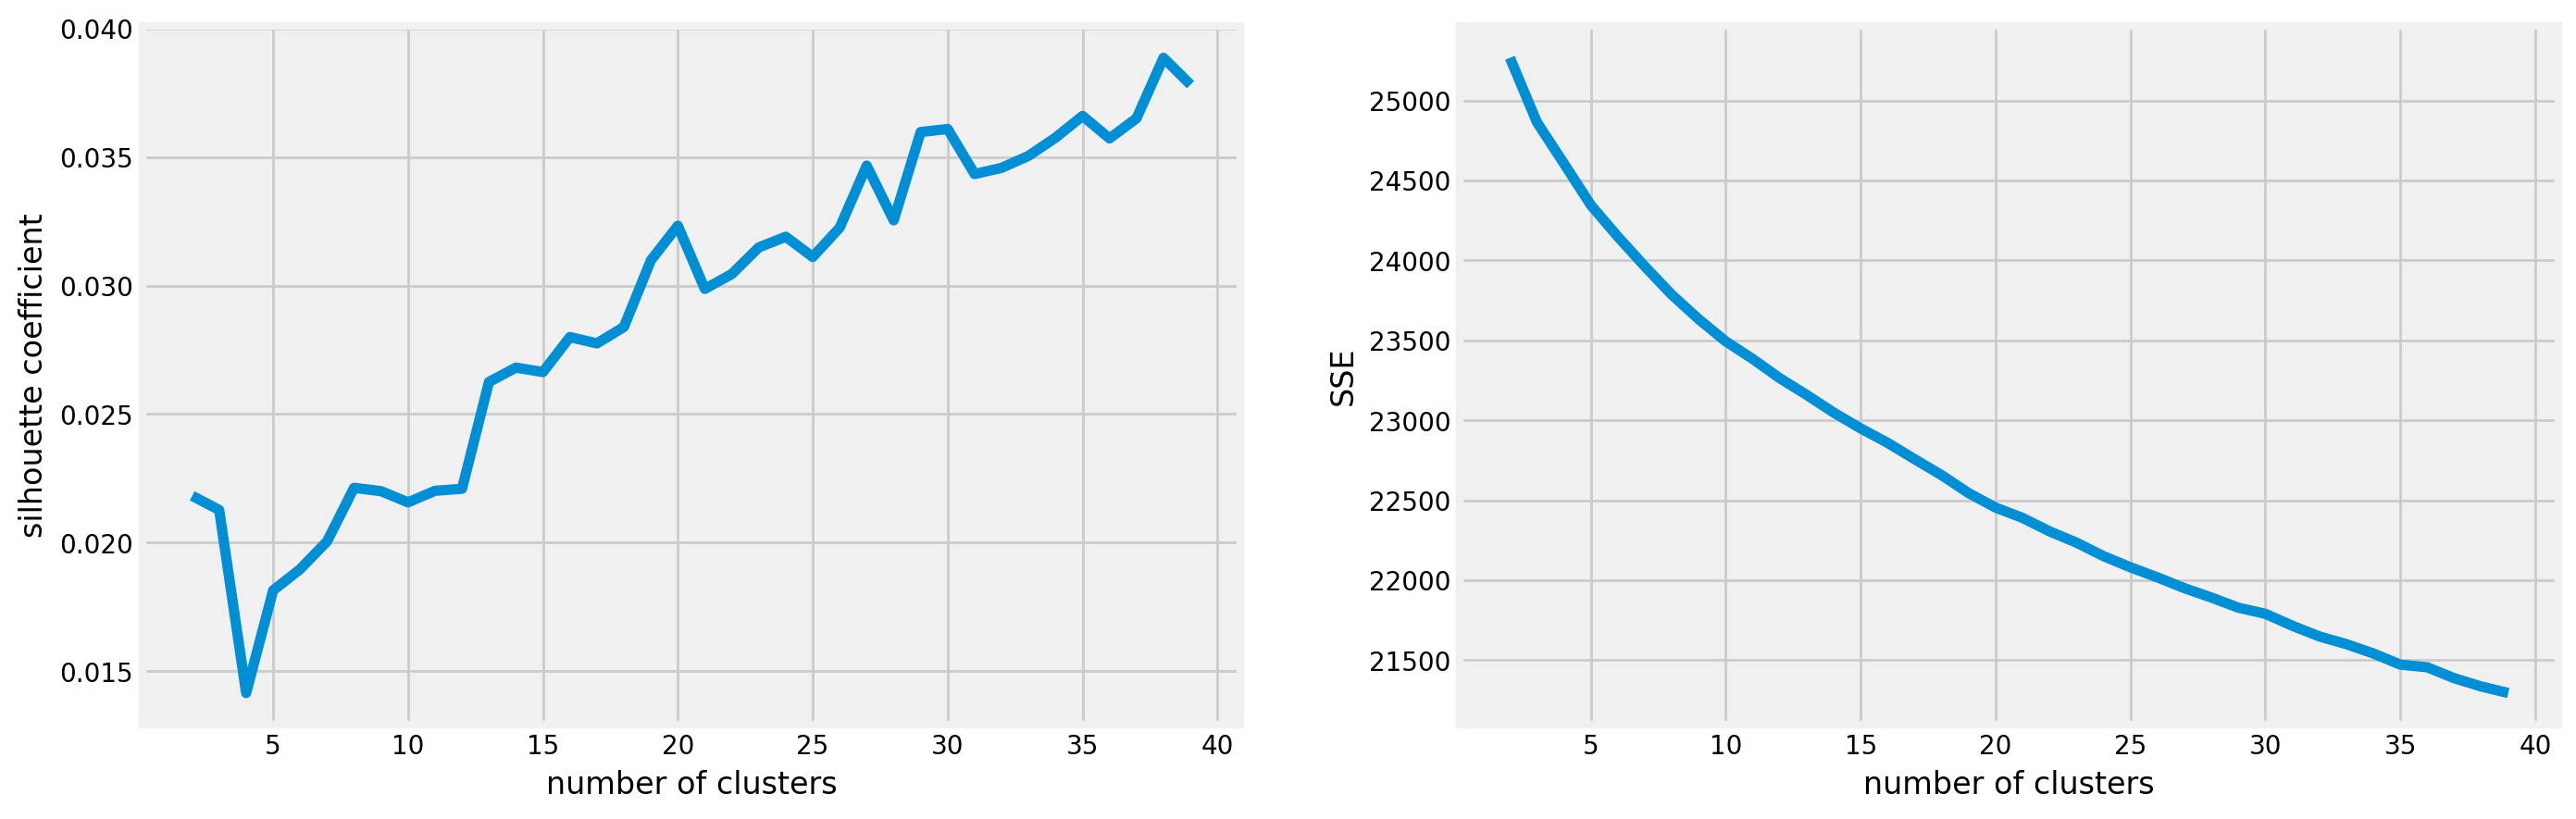

In [98]:
def plot_sil(try_clusters, Sil_coefs, SSEs):
    """ Function for visualizing/ finding the best clustering point """
    # Plot Silhouette scores
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,5), sharex=True, dpi=200)
    ax1.plot(try_clusters, Sil_coefs)
    ax1.title('Silhouette of Clusters')
    ax1.set_xlabel('Number of Clusters')
    ax1.set_ylabel('Silhouette Coefficient')

    # Plot errors
    ax2.plot(try_clusters, SSEs)
    ax2.title("Cluster's Error")
    ax2.set_xlabel('Number of Clusters')
    ax2.set_ylabel('SSE');
    
plot_sil(try_clusters=try_clusters, Sil_coefs=Sil_coefs, SSEs=SSes)

###### This suggests that there arent meaningful clusters in the normalized LS300 space. To test if 300 dimensions is too large, I will try clustering again with a reduced input.

In [ ]:
# Fix IndexError: index 10
lsi_red5 = matutils.corpus2dense(lsi_corpus, num_terms=10).transpose()
print('Reduced LSI space shape:', lsi_red5.shape)
print('Reduced LS space subset size in bytes:', sys.getsizeof(lsi_red5))

# Taking a subset for Kmeans due to memory dropout
lsi_red_sub5 = lsi_red5.copy()
np.random.shuffle(lsi_red_sub5)
lsi_red_sub5 = lsi_red_sub5[:5000]
lsi_red_sub5 = Normalizer(copy=False).fit_transform(lsi_red_sub5) # Normalized for the Euclidean metric
print('Reduced LSI space subset shape:', lsi_red_sub5.shape)
print('Reduced LS space subset size in bytes:', sys.getsizeof(lsi_red_sub5))

In [ ]:
%%time
SSEs, Sil_coefs, try_clusters = silhouette_co(start=2, stop=40, lsi_red_sub=lsi_red_sub)
plot_sil(try_clusters=try_clusters, Sil_coefs=Sil_coefs, SSEs=SSes)

###### Due to project deadlines, I was not able to complete this method but I wanted to preserve the effort and document the process for later use. I will move on to LDA.

In [56]:
# Cluster with the best results
#kmeans = KMeans(n_clusters=20, n_jobs=-2)
#lsi_clusters = kmeans.fit_predict(lsi_red)

# Take a look at the 
print(lsi_clusters[0:15])
df.text[0:2]

[0 0 0 0 0 0 0 0 0 0 7 0 0 0 0]


0    MEGA Pet Adoption Event! Cats, Dogs, a bunny: only $25 - includes spay, neuter &amp; vaccines. Saturday 9-4 Melbourne Wickham Park Community Center.\n\nThis is a 'cash 'n' carry' event - you will take your animal home that day. \n\nThere will be a huge variety of sizes, ages, breeds and personalities. If you want a cat that has a dog personality, they probably have a few Maine Coon cats (imagine a cat with the personality of Snoop Dogg or Willie Nelson). If you want an older, quiet, couch-potato dog - it shouldn't be hard to find one.\n\nThis is also kitten season. You could probably pick up a six-pack if you'd like, or find a few to match your preferred color of decor. Have a favorite Coach bag? Get a cat with fur to match so the shedding doesn't show.  Huge selection. Huge. \n\nHave you longed to have a dog named Tripod or Tippy? This is your chance. No guarantees, but again, chances are good. \n\nDo you love the Buccaneers? Talk like a pirate day? Know the punchline to a pirate

In [ ]:
from sklearn.metrics import silhouette_samples, silhouette_score

# Validating cluster performance
# Select range around best result, plot the silhouette distributions for each cluster
for k in range(14,17):
    plt.figure(dpi=120, figsize=(8,6))
    ax1 = plt.gca()
    km = KMeans(n_clusters=k, random_state=1)
    km.fit(X)
    labels = km.labels_
    silhouette_avg = silhouette_score(X, labels)
    print("For n_clusters =", k,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, labels)
    y_lower = 100
    for i in range(k):
        # Aggregate the silhouette scores for samples belonging to cluster i
        ith_cluster_silhouette_values = sample_silhouette_values[labels == i]
        
        #Sort
        ith_cluster_silhouette_values.sort()
        
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = plt.cm.spectral(float(i) / k)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples
    
    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

## <a id='lda'></a> Latent Dirichlet Allocation (LDA)

In [102]:
%%time
run = False

passes = 85
if run==True:
    lda = models.LdaMulticore(corpus=cv_corpus, num_topics=15, id2word=id2word, passes=passes, 
                              workers=13, random_state=42, eval_every=None, chunksize=6000)

2018-03-08 22:48:40,670 : INFO : using symmetric alpha at 0.06666666666666667
2018-03-08 22:48:40,673 : INFO : using symmetric eta at 0.06666666666666667
2018-03-08 22:48:40,689 : INFO : using serial LDA version on this node
2018-03-08 22:48:40,811 : INFO : running online LDA training, 15 topics, 100 passes over the supplied corpus of 146996 documents, updating every 78000 documents, evaluating every ~0 documents, iterating 50x with a convergence threshold of 0.001000
2018-03-08 22:48:40,815 : INFO : training LDA model using 13 processes
2018-03-08 22:48:43,307 : INFO : PROGRESS: pass 0, dispatched chunk #0 = documents up to #6000/146996, outstanding queue size 1
2018-03-08 22:48:52,172 : INFO : PROGRESS: pass 0, dispatched chunk #1 = documents up to #12000/146996, outstanding queue size 2
2018-03-08 22:48:58,812 : INFO : PROGRESS: pass 0, dispatched chunk #2 = documents up to #18000/146996, outstanding queue size 3
2018-03-08 22:49:05,247 : INFO : PROGRESS: pass 0, dispatched chunk #3

2018-03-08 22:53:46,206 : INFO : topic #1 (0.067): 0.004*"first" + 0.004*"way" + 0.003*"back" + 0.003*"game" + 0.003*"still" + 0.003*"new" + 0.003*"make" + 0.003*"something" + 0.003*"good" + 0.003*"around"
2018-03-08 22:53:46,212 : INFO : topic #6 (0.067): 0.004*"new" + 0.003*"right" + 0.003*"first" + 0.003*"much" + 0.003*"world" + 0.003*"going" + 0.002*"way" + 0.002*"said" + 0.002*"good" + 0.002*"last"
2018-03-08 22:53:46,216 : INFO : topic #13 (0.067): 0.004*"want" + 0.004*"way" + 0.004*"think" + 0.003*"see" + 0.003*"things" + 0.003*"game" + 0.003*"make" + 0.003*"much" + 0.003*"well" + 0.003*"back"
2018-03-08 22:53:46,218 : INFO : topic #0 (0.067): 0.006*"que" + 0.004*"game" + 0.003*"first" + 0.003*"want" + 0.003*"well" + 0.003*"think" + 0.003*"make" + 0.003*"still" + 0.003*"see" + 0.002*"way"
2018-03-08 22:53:46,220 : INFO : topic #4 (0.067): 0.005*"back" + 0.004*"first" + 0.004*"much" + 0.003*"make" + 0.003*"never" + 0.003*"think" + 0.003*"said" + 0.003*"game" + 0.003*"two" + 0.003

2018-03-08 22:58:12,398 : INFO : topic #14 (0.067): 0.007*"game" + 0.007*"team" + 0.004*"damage" + 0.004*"players" + 0.004*"play" + 0.003*"season" + 0.003*"new" + 0.003*"first" + 0.003*"see" + 0.003*"make"
2018-03-08 22:58:12,401 : INFO : topic #8 (0.067): 0.005*"work" + 0.004*"life" + 0.004*"job" + 0.003*"back" + 0.003*"things" + 0.003*"want" + 0.003*"make" + 0.003*"new" + 0.003*"something" + 0.003*"first"
2018-03-08 22:58:12,403 : INFO : topic #9 (0.067): 0.005*"think" + 0.004*"see" + 0.004*"back" + 0.004*"said" + 0.003*"much" + 0.003*"well" + 0.003*"make" + 0.003*"way" + 0.003*"man" + 0.003*"going"
2018-03-08 22:58:12,405 : INFO : topic #12 (0.067): 0.006*"game" + 0.004*"scores" + 0.003*"score" + 0.003*"first" + 0.003*"ball" + 0.003*"episode" + 0.003*"line" + 0.003*"year" + 0.003*"2016" + 0.003*"two"
2018-03-08 22:58:12,407 : INFO : topic diff=0.202339, rho=0.190695
2018-03-08 22:58:12,592 : INFO : PROGRESS: pass 3, dispatched chunk #0 = documents up to #6000/146996, outstanding que

2018-03-08 23:03:05,096 : INFO : PROGRESS: pass 4, dispatched chunk #14 = documents up to #90000/146996, outstanding queue size 3
2018-03-08 23:03:12,205 : INFO : merging changes from 78000 documents into a model of 146996 documents
2018-03-08 23:03:12,326 : INFO : topic #5 (0.067): 0.007*"back" + 0.005*"got" + 0.004*"around" + 0.004*"going" + 0.004*"first" + 0.004*"day" + 0.003*"said" + 0.003*"still" + 0.003*"right" + 0.003*"something"
2018-03-08 23:03:12,331 : INFO : topic #2 (0.067): 0.012*"game" + 0.006*"games" + 0.005*"new" + 0.004*"play" + 0.004*"good" + 0.004*"think" + 0.004*"make" + 0.004*"much" + 0.003*"want" + 0.003*"need"
2018-03-08 23:03:12,336 : INFO : topic #11 (0.067): 0.004*"windows" + 0.003*"price" + 0.003*"want" + 0.003*"card" + 0.003*"purchase" + 0.003*"right" + 0.003*"good" + 0.003*"see" + 0.003*"new" + 0.003*"much"
2018-03-08 23:03:12,340 : INFO : topic #1 (0.067): 0.004*"first" + 0.003*"way" + 0.003*"game" + 0.003*"make" + 0.003*"new" + 0.003*"back" + 0.003*"much"

2018-03-08 23:07:40,466 : INFO : merging changes from 68996 documents into a model of 146996 documents
2018-03-08 23:07:40,563 : INFO : topic #11 (0.067): 0.005*"windows" + 0.004*"price" + 0.004*"card" + 0.004*"purchase" + 0.003*"amazon" + 0.003*"want" + 0.003*"key" + 0.003*"new" + 0.003*"good" + 0.003*"see"
2018-03-08 23:07:40,566 : INFO : topic #5 (0.067): 0.008*"back" + 0.005*"got" + 0.004*"around" + 0.004*"day" + 0.004*"going" + 0.004*"first" + 0.004*"said" + 0.003*"still" + 0.003*"right" + 0.003*"see"
2018-03-08 23:07:40,568 : INFO : topic #10 (0.067): 0.006*"think" + 0.004*"trump" + 0.004*"vote" + 0.004*"want" + 0.003*"show" + 0.003*"make" + 0.003*"book" + 0.003*"well" + 0.003*"much" + 0.003*"see"
2018-03-08 23:07:40,569 : INFO : topic #14 (0.067): 0.008*"game" + 0.008*"team" + 0.006*"damage" + 0.005*"players" + 0.004*"play" + 0.003*"player" + 0.003*"good" + 0.003*"season" + 0.003*"use" + 0.003*"new"
2018-03-08 23:07:40,571 : INFO : topic #3 (0.067): 0.006*"want" + 0.006*"going" 

2018-03-08 23:12:08,818 : INFO : PROGRESS: pass 7, dispatched chunk #11 = documents up to #72000/146996, outstanding queue size 3
2018-03-08 23:12:16,086 : INFO : PROGRESS: pass 7, dispatched chunk #12 = documents up to #78000/146996, outstanding queue size 3
2018-03-08 23:12:23,430 : INFO : PROGRESS: pass 7, dispatched chunk #13 = documents up to #84000/146996, outstanding queue size 3
2018-03-08 23:12:30,741 : INFO : PROGRESS: pass 7, dispatched chunk #14 = documents up to #90000/146996, outstanding queue size 3
2018-03-08 23:12:37,739 : INFO : merging changes from 78000 documents into a model of 146996 documents
2018-03-08 23:12:37,837 : INFO : topic #7 (0.067): 0.008*"game" + 0.006*"team" + 0.004*"well" + 0.004*"players" + 0.004*"match" + 0.004*"see" + 0.003*"good" + 0.003*"think" + 0.003*"play" + 0.003*"first"
2018-03-08 23:12:37,840 : INFO : topic #11 (0.067): 0.005*"windows" + 0.005*"price" + 0.005*"card" + 0.004*"purchase" + 0.004*"amazon" + 0.003*"key" + 0.003*"new" + 0.003*"b

2018-03-08 23:16:41,031 : INFO : PROGRESS: pass 8, dispatched chunk #22 = documents up to #138000/146996, outstanding queue size 3
2018-03-08 23:16:48,547 : INFO : PROGRESS: pass 8, dispatched chunk #23 = documents up to #144000/146996, outstanding queue size 3
2018-03-08 23:16:55,741 : INFO : PROGRESS: pass 8, dispatched chunk #24 = documents up to #146996/146996, outstanding queue size 3
2018-03-08 23:17:06,025 : INFO : merging changes from 68996 documents into a model of 146996 documents
2018-03-08 23:17:06,123 : INFO : topic #4 (0.067): 0.003*"world" + 0.003*"first" + 0.003*"war" + 0.003*"think" + 0.003*"make" + 0.002*"god" + 0.002*"much" + 0.002*"may" + 0.002*"way" + 0.002*"country"
2018-03-08 23:17:06,126 : INFO : topic #14 (0.067): 0.008*"game" + 0.008*"damage" + 0.007*"team" + 0.005*"players" + 0.004*"play" + 0.003*"player" + 0.003*"good" + 0.003*"use" + 0.003*"level" + 0.003*"attack"
2018-03-08 23:17:06,128 : INFO : topic #10 (0.067): 0.006*"think" + 0.005*"trump" + 0.005*"vot

2018-03-08 23:21:12,432 : INFO : PROGRESS: pass 10, dispatched chunk #8 = documents up to #54000/146996, outstanding queue size 3
2018-03-08 23:21:19,698 : INFO : PROGRESS: pass 10, dispatched chunk #9 = documents up to #60000/146996, outstanding queue size 3
2018-03-08 23:21:27,096 : INFO : PROGRESS: pass 10, dispatched chunk #10 = documents up to #66000/146996, outstanding queue size 3
2018-03-08 23:21:34,279 : INFO : PROGRESS: pass 10, dispatched chunk #11 = documents up to #72000/146996, outstanding queue size 3
2018-03-08 23:21:41,552 : INFO : PROGRESS: pass 10, dispatched chunk #12 = documents up to #78000/146996, outstanding queue size 3
2018-03-08 23:21:48,441 : INFO : PROGRESS: pass 10, dispatched chunk #13 = documents up to #84000/146996, outstanding queue size 3
2018-03-08 23:21:56,040 : INFO : PROGRESS: pass 10, dispatched chunk #14 = documents up to #90000/146996, outstanding queue size 4
2018-03-08 23:22:03,184 : INFO : merging changes from 78000 documents into a model of

2018-03-08 23:25:42,147 : INFO : PROGRESS: pass 11, dispatched chunk #19 = documents up to #120000/146996, outstanding queue size 3
2018-03-08 23:25:49,127 : INFO : PROGRESS: pass 11, dispatched chunk #20 = documents up to #126000/146996, outstanding queue size 2
2018-03-08 23:25:55,990 : INFO : PROGRESS: pass 11, dispatched chunk #21 = documents up to #132000/146996, outstanding queue size 3
2018-03-08 23:26:03,284 : INFO : PROGRESS: pass 11, dispatched chunk #22 = documents up to #138000/146996, outstanding queue size 3
2018-03-08 23:26:10,560 : INFO : PROGRESS: pass 11, dispatched chunk #23 = documents up to #144000/146996, outstanding queue size 3
2018-03-08 23:26:17,973 : INFO : PROGRESS: pass 11, dispatched chunk #24 = documents up to #146996/146996, outstanding queue size 3
2018-03-08 23:26:27,914 : INFO : merging changes from 68996 documents into a model of 146996 documents
2018-03-08 23:26:28,014 : INFO : topic #1 (0.067): 0.004*"first" + 0.003*"make" + 0.003*"use" + 0.003*"ne

2018-03-08 23:30:11,022 : INFO : PROGRESS: pass 13, dispatched chunk #5 = documents up to #36000/146996, outstanding queue size 3
2018-03-08 23:30:18,588 : INFO : PROGRESS: pass 13, dispatched chunk #6 = documents up to #42000/146996, outstanding queue size 3
2018-03-08 23:30:25,897 : INFO : PROGRESS: pass 13, dispatched chunk #7 = documents up to #48000/146996, outstanding queue size 3
2018-03-08 23:30:35,172 : INFO : PROGRESS: pass 13, dispatched chunk #8 = documents up to #54000/146996, outstanding queue size 3
2018-03-08 23:30:42,278 : INFO : PROGRESS: pass 13, dispatched chunk #9 = documents up to #60000/146996, outstanding queue size 3
2018-03-08 23:30:49,903 : INFO : PROGRESS: pass 13, dispatched chunk #10 = documents up to #66000/146996, outstanding queue size 3
2018-03-08 23:30:57,253 : INFO : PROGRESS: pass 13, dispatched chunk #11 = documents up to #72000/146996, outstanding queue size 3
2018-03-08 23:31:04,593 : INFO : PROGRESS: pass 13, dispatched chunk #12 = documents up 

2018-03-08 23:34:42,785 : INFO : PROGRESS: pass 14, dispatched chunk #16 = documents up to #102000/146996, outstanding queue size 3
2018-03-08 23:34:50,130 : INFO : PROGRESS: pass 14, dispatched chunk #17 = documents up to #108000/146996, outstanding queue size 3
2018-03-08 23:34:57,686 : INFO : PROGRESS: pass 14, dispatched chunk #18 = documents up to #114000/146996, outstanding queue size 3
2018-03-08 23:35:05,240 : INFO : PROGRESS: pass 14, dispatched chunk #19 = documents up to #120000/146996, outstanding queue size 3
2018-03-08 23:35:12,676 : INFO : PROGRESS: pass 14, dispatched chunk #20 = documents up to #126000/146996, outstanding queue size 3
2018-03-08 23:35:21,929 : INFO : PROGRESS: pass 14, dispatched chunk #21 = documents up to #132000/146996, outstanding queue size 3
2018-03-08 23:35:28,975 : INFO : PROGRESS: pass 14, dispatched chunk #22 = documents up to #138000/146996, outstanding queue size 2
2018-03-08 23:35:36,037 : INFO : PROGRESS: pass 14, dispatched chunk #23 = d

2018-03-08 23:39:14,214 : INFO : PROGRESS: pass 16, dispatched chunk #2 = documents up to #18000/146996, outstanding queue size 3
2018-03-08 23:39:20,910 : INFO : PROGRESS: pass 16, dispatched chunk #3 = documents up to #24000/146996, outstanding queue size 3
2018-03-08 23:39:28,405 : INFO : PROGRESS: pass 16, dispatched chunk #4 = documents up to #30000/146996, outstanding queue size 3
2018-03-08 23:39:35,849 : INFO : PROGRESS: pass 16, dispatched chunk #5 = documents up to #36000/146996, outstanding queue size 3
2018-03-08 23:39:43,154 : INFO : PROGRESS: pass 16, dispatched chunk #6 = documents up to #42000/146996, outstanding queue size 3
2018-03-08 23:39:50,537 : INFO : PROGRESS: pass 16, dispatched chunk #7 = documents up to #48000/146996, outstanding queue size 3
2018-03-08 23:39:57,899 : INFO : PROGRESS: pass 16, dispatched chunk #8 = documents up to #54000/146996, outstanding queue size 3
2018-03-08 23:40:07,188 : INFO : PROGRESS: pass 16, dispatched chunk #9 = documents up to 

2018-03-08 23:43:59,668 : INFO : topic #9 (0.067): 0.005*"man" + 0.004*"men" + 0.004*"see" + 0.004*"think" + 0.004*"back" + 0.004*"said" + 0.003*"lord" + 0.003*"death" + 0.003*"way" + 0.003*"well"
2018-03-08 23:43:59,671 : INFO : topic diff=0.188901, rho=0.153394
2018-03-08 23:43:59,889 : INFO : PROGRESS: pass 17, dispatched chunk #15 = documents up to #96000/146996, outstanding queue size 3
2018-03-08 23:44:07,314 : INFO : PROGRESS: pass 17, dispatched chunk #16 = documents up to #102000/146996, outstanding queue size 3
2018-03-08 23:44:14,787 : INFO : PROGRESS: pass 17, dispatched chunk #17 = documents up to #108000/146996, outstanding queue size 3
2018-03-08 23:44:22,348 : INFO : PROGRESS: pass 17, dispatched chunk #18 = documents up to #114000/146996, outstanding queue size 3
2018-03-08 23:44:29,997 : INFO : PROGRESS: pass 17, dispatched chunk #19 = documents up to #120000/146996, outstanding queue size 3
2018-03-08 23:44:37,327 : INFO : PROGRESS: pass 17, dispatched chunk #20 = do

2018-03-08 23:48:26,070 : INFO : topic #2 (0.067): 0.019*"game" + 0.008*"games" + 0.007*"play" + 0.006*"new" + 0.005*"think" + 0.004*"much" + 0.004*"playing" + 0.004*"good" + 0.004*"first" + 0.004*"want"
2018-03-08 23:48:26,072 : INFO : topic diff=0.165840, rho=0.151621
2018-03-08 23:48:26,259 : INFO : PROGRESS: pass 19, dispatched chunk #0 = documents up to #6000/146996, outstanding queue size 1
2018-03-08 23:48:32,127 : INFO : PROGRESS: pass 19, dispatched chunk #1 = documents up to #12000/146996, outstanding queue size 2
2018-03-08 23:48:39,309 : INFO : PROGRESS: pass 19, dispatched chunk #2 = documents up to #18000/146996, outstanding queue size 3
2018-03-08 23:48:46,400 : INFO : PROGRESS: pass 19, dispatched chunk #3 = documents up to #24000/146996, outstanding queue size 3
2018-03-08 23:48:53,604 : INFO : PROGRESS: pass 19, dispatched chunk #4 = documents up to #30000/146996, outstanding queue size 4
2018-03-08 23:49:01,148 : INFO : PROGRESS: pass 19, dispatched chunk #5 = docume

2018-03-08 23:53:23,828 : INFO : topic #11 (0.067): 0.008*"price" + 0.008*"card" + 0.007*"windows" + 0.006*"purchase" + 0.005*"amazon" + 0.005*"buy" + 0.005*"pokemon" + 0.004*"shipping" + 0.004*"box" + 0.004*"key"
2018-03-08 23:53:23,830 : INFO : topic #4 (0.067): 0.004*"world" + 0.003*"war" + 0.003*"think" + 0.003*"believe" + 0.003*"may" + 0.002*"country" + 0.002*"way" + 0.002*"god" + 0.002*"church" + 0.002*"make"
2018-03-08 23:53:23,832 : INFO : topic #8 (0.067): 0.009*"work" + 0.007*"money" + 0.006*"job" + 0.005*"year" + 0.005*"pay" + 0.004*"need" + 0.004*"years" + 0.004*"company" + 0.004*"new" + 0.004*"want"
2018-03-08 23:53:23,834 : INFO : topic #3 (0.067): 0.008*"want" + 0.007*"feel" + 0.006*"going" + 0.006*"think" + 0.006*"never" + 0.005*"life" + 0.005*"things" + 0.005*"much" + 0.005*"said" + 0.005*"got"
2018-03-08 23:53:23,836 : INFO : topic diff=0.141655, rho=0.148251
2018-03-08 23:53:24,056 : INFO : PROGRESS: pass 20, dispatched chunk #15 = documents up to #96000/146996, outs

2018-03-08 23:57:49,023 : INFO : topic #12 (0.067): 0.011*"game" + 0.007*"ball" + 0.007*"2016" + 0.007*"scores" + 0.007*"score" + 0.006*"icon" + 0.006*"season" + 0.005*"line" + 0.005*"bar" + 0.005*"team"
2018-03-08 23:57:49,025 : INFO : topic #5 (0.067): 0.009*"back" + 0.005*"got" + 0.005*"around" + 0.004*"said" + 0.004*"day" + 0.004*"went" + 0.004*"going" + 0.004*"room" + 0.004*"first" + 0.004*"see"
2018-03-08 23:57:49,027 : INFO : topic #6 (0.067): 0.011*"chapter" + 0.010*"world" + 0.005*"table" + 0.005*"synopsis" + 0.005*"links" + 0.004*"previous" + 0.004*"source" + 0.004*"new" + 0.004*"contents" + 0.004*"man"
2018-03-08 23:57:49,030 : INFO : topic #9 (0.067): 0.005*"man" + 0.004*"see" + 0.004*"men" + 0.004*"back" + 0.004*"think" + 0.004*"lord" + 0.003*"said" + 0.003*"death" + 0.003*"way" + 0.003*"king"
2018-03-08 23:57:49,032 : INFO : topic diff=0.124204, rho=0.146648
2018-03-08 23:57:51,031 : INFO : PROGRESS: pass 22, dispatched chunk #0 = documents up to #6000/146996, outstanding

2018-03-09 00:02:36,833 : INFO : PROGRESS: pass 23, dispatched chunk #13 = documents up to #84000/146996, outstanding queue size 3
2018-03-09 00:02:44,147 : INFO : PROGRESS: pass 23, dispatched chunk #14 = documents up to #90000/146996, outstanding queue size 3
2018-03-09 00:02:50,905 : INFO : merging changes from 78000 documents into a model of 146996 documents
2018-03-09 00:02:51,017 : INFO : topic #1 (0.067): 0.003*"first" + 0.003*"use" + 0.003*"make" + 0.003*"well" + 0.003*"water" + 0.003*"new" + 0.003*"two" + 0.003*"much" + 0.003*"used" + 0.002*"way"
2018-03-09 00:02:51,019 : INFO : topic #11 (0.067): 0.008*"price" + 0.008*"card" + 0.007*"windows" + 0.006*"purchase" + 0.005*"amazon" + 0.005*"buy" + 0.005*"pokemon" + 0.004*"box" + 0.004*"shipping" + 0.004*"key"
2018-03-09 00:02:51,021 : INFO : topic #4 (0.067): 0.004*"world" + 0.003*"war" + 0.003*"think" + 0.003*"believe" + 0.003*"may" + 0.002*"country" + 0.002*"way" + 0.002*"church" + 0.002*"women" + 0.002*"god"
2018-03-09 00:02:5

2018-03-09 00:11:29,793 : INFO : PROGRESS: pass 26, dispatched chunk #9 = documents up to #60000/146996, outstanding queue size 3
2018-03-09 00:11:37,336 : INFO : PROGRESS: pass 26, dispatched chunk #10 = documents up to #66000/146996, outstanding queue size 3
2018-03-09 00:11:44,396 : INFO : PROGRESS: pass 26, dispatched chunk #11 = documents up to #72000/146996, outstanding queue size 3
2018-03-09 00:11:51,749 : INFO : PROGRESS: pass 26, dispatched chunk #12 = documents up to #78000/146996, outstanding queue size 3
2018-03-09 00:11:59,017 : INFO : PROGRESS: pass 26, dispatched chunk #13 = documents up to #84000/146996, outstanding queue size 3
2018-03-09 00:12:06,453 : INFO : PROGRESS: pass 26, dispatched chunk #14 = documents up to #90000/146996, outstanding queue size 3
2018-03-09 00:12:13,475 : INFO : merging changes from 78000 documents into a model of 146996 documents
2018-03-09 00:12:13,587 : INFO : topic #1 (0.067): 0.003*"use" + 0.003*"first" + 0.003*"make" + 0.003*"water" + 

2018-03-09 00:16:01,328 : INFO : PROGRESS: pass 27, dispatched chunk #20 = documents up to #126000/146996, outstanding queue size 3
2018-03-09 00:16:08,087 : INFO : PROGRESS: pass 27, dispatched chunk #21 = documents up to #132000/146996, outstanding queue size 3
2018-03-09 00:16:15,640 : INFO : PROGRESS: pass 27, dispatched chunk #22 = documents up to #138000/146996, outstanding queue size 3
2018-03-09 00:16:22,918 : INFO : PROGRESS: pass 27, dispatched chunk #23 = documents up to #144000/146996, outstanding queue size 3
2018-03-09 00:16:30,332 : INFO : PROGRESS: pass 27, dispatched chunk #24 = documents up to #146996/146996, outstanding queue size 3
2018-03-09 00:16:40,361 : INFO : merging changes from 68996 documents into a model of 146996 documents
2018-03-09 00:16:40,463 : INFO : topic #14 (0.067): 0.010*"damage" + 0.006*"game" + 0.005*"level" + 0.004*"use" + 0.004*"attack" + 0.004*"good" + 0.003*"hero" + 0.003*"hit" + 0.003*"players" + 0.003*"make"
2018-03-09 00:16:40,465 : INFO 

2018-03-09 00:20:31,361 : INFO : PROGRESS: pass 29, dispatched chunk #6 = documents up to #42000/146996, outstanding queue size 3
2018-03-09 00:20:38,520 : INFO : PROGRESS: pass 29, dispatched chunk #7 = documents up to #48000/146996, outstanding queue size 3
2018-03-09 00:20:45,993 : INFO : PROGRESS: pass 29, dispatched chunk #8 = documents up to #54000/146996, outstanding queue size 3
2018-03-09 00:20:53,248 : INFO : PROGRESS: pass 29, dispatched chunk #9 = documents up to #60000/146996, outstanding queue size 3
2018-03-09 00:21:00,746 : INFO : PROGRESS: pass 29, dispatched chunk #10 = documents up to #66000/146996, outstanding queue size 3
2018-03-09 00:21:07,914 : INFO : PROGRESS: pass 29, dispatched chunk #11 = documents up to #72000/146996, outstanding queue size 3
2018-03-09 00:21:15,257 : INFO : PROGRESS: pass 29, dispatched chunk #12 = documents up to #78000/146996, outstanding queue size 4
2018-03-09 00:21:22,503 : INFO : PROGRESS: pass 29, dispatched chunk #13 = documents up

2018-03-09 00:24:52,425 : INFO : PROGRESS: pass 30, dispatched chunk #16 = documents up to #102000/146996, outstanding queue size 3
2018-03-09 00:25:01,678 : INFO : PROGRESS: pass 30, dispatched chunk #17 = documents up to #108000/146996, outstanding queue size 3
2018-03-09 00:25:08,540 : INFO : PROGRESS: pass 30, dispatched chunk #18 = documents up to #114000/146996, outstanding queue size 3
2018-03-09 00:25:16,206 : INFO : PROGRESS: pass 30, dispatched chunk #19 = documents up to #120000/146996, outstanding queue size 3
2018-03-09 00:25:23,716 : INFO : PROGRESS: pass 30, dispatched chunk #20 = documents up to #126000/146996, outstanding queue size 3
2018-03-09 00:25:31,054 : INFO : PROGRESS: pass 30, dispatched chunk #21 = documents up to #132000/146996, outstanding queue size 3
2018-03-09 00:25:38,377 : INFO : PROGRESS: pass 30, dispatched chunk #22 = documents up to #138000/146996, outstanding queue size 3
2018-03-09 00:25:45,380 : INFO : PROGRESS: pass 30, dispatched chunk #23 = d

2018-03-09 00:29:17,022 : INFO : PROGRESS: pass 32, dispatched chunk #1 = documents up to #12000/146996, outstanding queue size 2
2018-03-09 00:29:24,300 : INFO : PROGRESS: pass 32, dispatched chunk #2 = documents up to #18000/146996, outstanding queue size 3
2018-03-09 00:29:31,272 : INFO : PROGRESS: pass 32, dispatched chunk #3 = documents up to #24000/146996, outstanding queue size 3
2018-03-09 00:29:38,402 : INFO : PROGRESS: pass 32, dispatched chunk #4 = documents up to #30000/146996, outstanding queue size 3
2018-03-09 00:29:47,809 : INFO : PROGRESS: pass 32, dispatched chunk #5 = documents up to #36000/146996, outstanding queue size 3
2018-03-09 00:29:54,680 : INFO : PROGRESS: pass 32, dispatched chunk #6 = documents up to #42000/146996, outstanding queue size 3
2018-03-09 00:30:01,718 : INFO : PROGRESS: pass 32, dispatched chunk #7 = documents up to #48000/146996, outstanding queue size 3
2018-03-09 00:30:08,944 : INFO : PROGRESS: pass 32, dispatched chunk #8 = documents up to 

2018-03-09 00:34:08,656 : INFO : topic #7 (0.067): 0.026*"team" + 0.016*"game" + 0.012*"players" + 0.010*"match" + 0.008*"play" + 0.007*"teams" + 0.007*"win" + 0.006*"games" + 0.006*"player" + 0.005*"league"
2018-03-09 00:34:08,657 : INFO : topic #8 (0.067): 0.009*"work" + 0.007*"money" + 0.006*"job" + 0.006*"year" + 0.005*"need" + 0.004*"pay" + 0.004*"years" + 0.004*"new" + 0.004*"back" + 0.004*"company"
2018-03-09 00:34:08,659 : INFO : topic diff=0.050199, rho=0.130745
2018-03-09 00:34:08,878 : INFO : PROGRESS: pass 33, dispatched chunk #15 = documents up to #96000/146996, outstanding queue size 3
2018-03-09 00:34:16,537 : INFO : PROGRESS: pass 33, dispatched chunk #16 = documents up to #102000/146996, outstanding queue size 3
2018-03-09 00:34:24,169 : INFO : PROGRESS: pass 33, dispatched chunk #17 = documents up to #108000/146996, outstanding queue size 4
2018-03-09 00:34:33,479 : INFO : PROGRESS: pass 33, dispatched chunk #18 = documents up to #114000/146996, outstanding queue size

2018-03-09 00:38:34,619 : INFO : topic #4 (0.067): 0.004*"world" + 0.003*"war" + 0.003*"women" + 0.003*"think" + 0.003*"believe" + 0.003*"may" + 0.002*"way" + 0.002*"country" + 0.002*"men" + 0.002*"church"
2018-03-09 00:38:34,621 : INFO : topic diff=0.046407, rho=0.129641
2018-03-09 00:38:34,808 : INFO : PROGRESS: pass 35, dispatched chunk #0 = documents up to #6000/146996, outstanding queue size 1
2018-03-09 00:38:40,614 : INFO : PROGRESS: pass 35, dispatched chunk #1 = documents up to #12000/146996, outstanding queue size 2
2018-03-09 00:38:47,876 : INFO : PROGRESS: pass 35, dispatched chunk #2 = documents up to #18000/146996, outstanding queue size 3
2018-03-09 00:38:54,808 : INFO : PROGRESS: pass 35, dispatched chunk #3 = documents up to #24000/146996, outstanding queue size 3
2018-03-09 00:39:01,854 : INFO : PROGRESS: pass 35, dispatched chunk #4 = documents up to #30000/146996, outstanding queue size 3
2018-03-09 00:39:09,668 : INFO : PROGRESS: pass 35, dispatched chunk #5 = docu

2018-03-09 00:43:32,802 : INFO : topic #10 (0.067): 0.009*"episode" + 0.008*"show" + 0.007*"think" + 0.006*"trump" + 0.006*"season" + 0.006*"vote" + 0.006*"character" + 0.005*"characters" + 0.005*"story" + 0.005*"see"
2018-03-09 00:43:32,806 : INFO : topic #12 (0.067): 0.011*"game" + 0.008*"ball" + 0.007*"scores" + 0.007*"score" + 0.006*"2016" + 0.006*"icon" + 0.006*"season" + 0.005*"line" + 0.005*"bar" + 0.005*"field"
2018-03-09 00:43:32,810 : INFO : topic #3 (0.067): 0.008*"want" + 0.007*"feel" + 0.006*"think" + 0.006*"going" + 0.006*"never" + 0.006*"life" + 0.005*"things" + 0.005*"much" + 0.005*"got" + 0.005*"said"
2018-03-09 00:43:32,814 : INFO : topic #6 (0.067): 0.013*"chapter" + 0.012*"world" + 0.005*"links" + 0.005*"table" + 0.005*"synopsis" + 0.005*"previous" + 0.004*"source" + 0.004*"contents" + 0.004*"life" + 0.004*"raw"
2018-03-09 00:43:32,819 : INFO : topic diff=0.042671, rho=0.127516
2018-03-09 00:43:33,077 : INFO : PROGRESS: pass 36, dispatched chunk #15 = documents up t

2018-03-09 00:48:00,592 : INFO : topic #4 (0.067): 0.004*"world" + 0.003*"women" + 0.003*"war" + 0.003*"think" + 0.003*"believe" + 0.003*"may" + 0.002*"men" + 0.002*"way" + 0.002*"country" + 0.002*"church"
2018-03-09 00:48:00,594 : INFO : topic #13 (0.067): 0.013*"post" + 0.010*"thread" + 0.009*"please" + 0.008*"new" + 0.007*"link" + 0.007*"questions" + 0.006*"want" + 0.005*"help" + 0.005*"make" + 0.005*"reddit"
2018-03-09 00:48:00,597 : INFO : topic #9 (0.067): 0.005*"man" + 0.004*"back" + 0.004*"death" + 0.004*"lord" + 0.004*"see" + 0.003*"think" + 0.003*"said" + 0.003*"first" + 0.003*"king" + 0.003*"men"
2018-03-09 00:48:00,599 : INFO : topic #14 (0.067): 0.011*"damage" + 0.006*"game" + 0.005*"level" + 0.005*"use" + 0.004*"attack" + 0.004*"good" + 0.003*"deck" + 0.003*"hit" + 0.003*"make" + 0.003*"hero"
2018-03-09 00:48:00,601 : INFO : topic diff=0.039540, rho=0.126492
2018-03-09 00:48:00,799 : INFO : PROGRESS: pass 38, dispatched chunk #0 = documents up to #6000/146996, outstanding

2018-03-09 00:52:43,958 : INFO : PROGRESS: pass 39, dispatched chunk #13 = documents up to #84000/146996, outstanding queue size 3
2018-03-09 00:52:50,921 : INFO : PROGRESS: pass 39, dispatched chunk #14 = documents up to #90000/146996, outstanding queue size 3
2018-03-09 00:52:58,461 : INFO : merging changes from 78000 documents into a model of 146996 documents
2018-03-09 00:52:58,584 : INFO : topic #10 (0.067): 0.010*"episode" + 0.008*"show" + 0.007*"think" + 0.006*"trump" + 0.006*"season" + 0.006*"vote" + 0.006*"character" + 0.005*"characters" + 0.005*"story" + 0.005*"see"
2018-03-09 00:52:58,587 : INFO : topic #7 (0.067): 0.027*"team" + 0.016*"game" + 0.012*"players" + 0.011*"match" + 0.008*"play" + 0.007*"win" + 0.007*"teams" + 0.007*"games" + 0.006*"player" + 0.005*"league"
2018-03-09 00:52:58,589 : INFO : topic #0 (0.067): 0.061*"que" + 0.027*"los" + 0.017*"por" + 0.017*"del" + 0.016*"con" + 0.016*"las" + 0.014*"para" + 0.012*"una" + 0.009*"como" + 0.007*"podemos"
2018-03-09 00:

2018-03-09 00:57:16,132 : INFO : PROGRESS: pass 40, dispatched chunk #24 = documents up to #146996/146996, outstanding queue size 3
2018-03-09 00:57:25,768 : INFO : merging changes from 68996 documents into a model of 146996 documents
2018-03-09 00:57:25,870 : INFO : topic #14 (0.067): 0.011*"damage" + 0.006*"game" + 0.005*"level" + 0.005*"use" + 0.004*"attack" + 0.004*"good" + 0.003*"deck" + 0.003*"hit" + 0.003*"make" + 0.003*"hero"
2018-03-09 00:57:25,874 : INFO : topic #5 (0.067): 0.010*"back" + 0.006*"around" + 0.006*"got" + 0.005*"said" + 0.004*"room" + 0.004*"day" + 0.004*"went" + 0.004*"night" + 0.004*"see" + 0.004*"going"
2018-03-09 00:57:25,876 : INFO : topic #10 (0.067): 0.010*"episode" + 0.008*"show" + 0.008*"think" + 0.006*"trump" + 0.006*"season" + 0.006*"vote" + 0.006*"character" + 0.005*"characters" + 0.005*"story" + 0.005*"see"
2018-03-09 00:57:25,879 : INFO : topic #4 (0.067): 0.004*"world" + 0.003*"women" + 0.003*"war" + 0.003*"think" + 0.003*"believe" + 0.003*"may" +

2018-03-09 01:01:48,720 : INFO : PROGRESS: pass 42, dispatched chunk #10 = documents up to #66000/146996, outstanding queue size 3
2018-03-09 01:01:55,689 : INFO : PROGRESS: pass 42, dispatched chunk #11 = documents up to #72000/146996, outstanding queue size 2
2018-03-09 01:02:02,886 : INFO : PROGRESS: pass 42, dispatched chunk #12 = documents up to #78000/146996, outstanding queue size 3
2018-03-09 01:02:10,143 : INFO : PROGRESS: pass 42, dispatched chunk #13 = documents up to #84000/146996, outstanding queue size 3
2018-03-09 01:02:17,409 : INFO : PROGRESS: pass 42, dispatched chunk #14 = documents up to #90000/146996, outstanding queue size 3
2018-03-09 01:02:24,544 : INFO : merging changes from 78000 documents into a model of 146996 documents
2018-03-09 01:02:24,659 : INFO : topic #14 (0.067): 0.011*"damage" + 0.006*"game" + 0.005*"level" + 0.005*"use" + 0.004*"attack" + 0.004*"good" + 0.003*"hit" + 0.003*"deck" + 0.003*"make" + 0.003*"enemy"
2018-03-09 01:02:24,665 : INFO : topic

2018-03-09 01:06:14,871 : INFO : PROGRESS: pass 43, dispatched chunk #21 = documents up to #132000/146996, outstanding queue size 3
2018-03-09 01:06:22,226 : INFO : PROGRESS: pass 43, dispatched chunk #22 = documents up to #138000/146996, outstanding queue size 3
2018-03-09 01:06:31,617 : INFO : PROGRESS: pass 43, dispatched chunk #23 = documents up to #144000/146996, outstanding queue size 3
2018-03-09 01:06:38,583 : INFO : PROGRESS: pass 43, dispatched chunk #24 = documents up to #146996/146996, outstanding queue size 3
2018-03-09 01:06:48,475 : INFO : merging changes from 68996 documents into a model of 146996 documents
2018-03-09 01:06:48,578 : INFO : topic #4 (0.067): 0.004*"world" + 0.003*"women" + 0.003*"war" + 0.003*"think" + 0.003*"believe" + 0.003*"may" + 0.003*"men" + 0.002*"way" + 0.002*"country" + 0.002*"government"
2018-03-09 01:06:48,580 : INFO : topic #6 (0.067): 0.013*"chapter" + 0.012*"world" + 0.005*"table" + 0.005*"links" + 0.005*"synopsis" + 0.005*"previous" + 0.00

2018-03-09 01:10:43,050 : INFO : PROGRESS: pass 45, dispatched chunk #7 = documents up to #48000/146996, outstanding queue size 3
2018-03-09 01:10:50,247 : INFO : PROGRESS: pass 45, dispatched chunk #8 = documents up to #54000/146996, outstanding queue size 3
2018-03-09 01:10:57,404 : INFO : PROGRESS: pass 45, dispatched chunk #9 = documents up to #60000/146996, outstanding queue size 3
2018-03-09 01:11:04,871 : INFO : PROGRESS: pass 45, dispatched chunk #10 = documents up to #66000/146996, outstanding queue size 3
2018-03-09 01:11:11,500 : INFO : PROGRESS: pass 45, dispatched chunk #11 = documents up to #72000/146996, outstanding queue size 3
2018-03-09 01:11:20,979 : INFO : PROGRESS: pass 45, dispatched chunk #12 = documents up to #78000/146996, outstanding queue size 3
2018-03-09 01:11:28,252 : INFO : PROGRESS: pass 45, dispatched chunk #13 = documents up to #84000/146996, outstanding queue size 2
2018-03-09 01:11:35,495 : INFO : PROGRESS: pass 45, dispatched chunk #14 = documents u

2018-03-09 01:15:03,833 : INFO : PROGRESS: pass 46, dispatched chunk #17 = documents up to #108000/146996, outstanding queue size 3
2018-03-09 01:15:11,117 : INFO : PROGRESS: pass 46, dispatched chunk #18 = documents up to #114000/146996, outstanding queue size 3
2018-03-09 01:15:18,804 : INFO : PROGRESS: pass 46, dispatched chunk #19 = documents up to #120000/146996, outstanding queue size 3
2018-03-09 01:15:26,057 : INFO : PROGRESS: pass 46, dispatched chunk #20 = documents up to #126000/146996, outstanding queue size 3
2018-03-09 01:15:32,615 : INFO : PROGRESS: pass 46, dispatched chunk #21 = documents up to #132000/146996, outstanding queue size 3
2018-03-09 01:15:40,068 : INFO : PROGRESS: pass 46, dispatched chunk #22 = documents up to #138000/146996, outstanding queue size 3
2018-03-09 01:15:47,255 : INFO : PROGRESS: pass 46, dispatched chunk #23 = documents up to #144000/146996, outstanding queue size 3
2018-03-09 01:15:54,695 : INFO : PROGRESS: pass 46, dispatched chunk #24 = d

2018-03-09 01:19:27,079 : INFO : PROGRESS: pass 48, dispatched chunk #2 = documents up to #18000/146996, outstanding queue size 3
2018-03-09 01:19:34,172 : INFO : PROGRESS: pass 48, dispatched chunk #3 = documents up to #24000/146996, outstanding queue size 3
2018-03-09 01:19:41,267 : INFO : PROGRESS: pass 48, dispatched chunk #4 = documents up to #30000/146996, outstanding queue size 3
2018-03-09 01:19:48,843 : INFO : PROGRESS: pass 48, dispatched chunk #5 = documents up to #36000/146996, outstanding queue size 3
2018-03-09 01:19:56,109 : INFO : PROGRESS: pass 48, dispatched chunk #6 = documents up to #42000/146996, outstanding queue size 3
2018-03-09 01:20:03,383 : INFO : PROGRESS: pass 48, dispatched chunk #7 = documents up to #48000/146996, outstanding queue size 3
2018-03-09 01:20:10,843 : INFO : PROGRESS: pass 48, dispatched chunk #8 = documents up to #54000/146996, outstanding queue size 3
2018-03-09 01:20:17,926 : INFO : PROGRESS: pass 48, dispatched chunk #9 = documents up to 

2018-03-09 01:24:09,725 : INFO : topic #14 (0.067): 0.011*"damage" + 0.005*"game" + 0.005*"level" + 0.005*"use" + 0.004*"attack" + 0.004*"good" + 0.003*"deck" + 0.003*"hit" + 0.003*"make" + 0.003*"enemy"
2018-03-09 01:24:09,727 : INFO : topic diff=0.024791, rho=0.115857
2018-03-09 01:24:09,950 : INFO : PROGRESS: pass 49, dispatched chunk #15 = documents up to #96000/146996, outstanding queue size 2
2018-03-09 01:24:17,403 : INFO : PROGRESS: pass 49, dispatched chunk #16 = documents up to #102000/146996, outstanding queue size 3
2018-03-09 01:24:24,719 : INFO : PROGRESS: pass 49, dispatched chunk #17 = documents up to #108000/146996, outstanding queue size 3
2018-03-09 01:24:32,045 : INFO : PROGRESS: pass 49, dispatched chunk #18 = documents up to #114000/146996, outstanding queue size 3
2018-03-09 01:24:39,699 : INFO : PROGRESS: pass 49, dispatched chunk #19 = documents up to #120000/146996, outstanding queue size 3
2018-03-09 01:24:46,931 : INFO : PROGRESS: pass 49, dispatched chunk #

2018-03-09 01:28:33,278 : INFO : topic diff=0.025174, rho=0.115088
2018-03-09 01:28:33,473 : INFO : PROGRESS: pass 51, dispatched chunk #0 = documents up to #6000/146996, outstanding queue size 1
2018-03-09 01:28:39,276 : INFO : PROGRESS: pass 51, dispatched chunk #1 = documents up to #12000/146996, outstanding queue size 2
2018-03-09 01:28:48,443 : INFO : PROGRESS: pass 51, dispatched chunk #2 = documents up to #18000/146996, outstanding queue size 3
2018-03-09 01:28:55,040 : INFO : PROGRESS: pass 51, dispatched chunk #3 = documents up to #24000/146996, outstanding queue size 2
2018-03-09 01:29:01,944 : INFO : PROGRESS: pass 51, dispatched chunk #4 = documents up to #30000/146996, outstanding queue size 3
2018-03-09 01:29:09,267 : INFO : PROGRESS: pass 51, dispatched chunk #5 = documents up to #36000/146996, outstanding queue size 3
2018-03-09 01:29:16,480 : INFO : PROGRESS: pass 51, dispatched chunk #6 = documents up to #42000/146996, outstanding queue size 3
2018-03-09 01:29:23,766 

2018-03-09 01:33:28,466 : INFO : topic #2 (0.067): 0.019*"game" + 0.008*"games" + 0.007*"play" + 0.007*"new" + 0.005*"think" + 0.005*"much" + 0.004*"playing" + 0.004*"good" + 0.004*"way" + 0.004*"see"
2018-03-09 01:33:28,467 : INFO : topic #9 (0.067): 0.005*"man" + 0.004*"death" + 0.004*"back" + 0.004*"lord" + 0.003*"see" + 0.003*"first" + 0.003*"think" + 0.003*"king" + 0.003*"dead" + 0.003*"way"
2018-03-09 01:33:28,469 : INFO : topic diff=0.023418, rho=0.113593
2018-03-09 01:33:30,712 : INFO : PROGRESS: pass 52, dispatched chunk #15 = documents up to #96000/146996, outstanding queue size 3
2018-03-09 01:33:37,682 : INFO : PROGRESS: pass 52, dispatched chunk #16 = documents up to #102000/146996, outstanding queue size 2
2018-03-09 01:33:44,866 : INFO : PROGRESS: pass 52, dispatched chunk #17 = documents up to #108000/146996, outstanding queue size 3
2018-03-09 01:33:52,044 : INFO : PROGRESS: pass 52, dispatched chunk #18 = documents up to #114000/146996, outstanding queue size 3
2018-0

2018-03-09 01:37:53,145 : INFO : topic #13 (0.067): 0.013*"post" + 0.010*"thread" + 0.010*"please" + 0.008*"new" + 0.007*"link" + 0.007*"questions" + 0.006*"want" + 0.005*"help" + 0.005*"reddit" + 0.005*"free"
2018-03-09 01:37:53,147 : INFO : topic diff=0.021991, rho=0.112867
2018-03-09 01:37:53,343 : INFO : PROGRESS: pass 54, dispatched chunk #0 = documents up to #6000/146996, outstanding queue size 1
2018-03-09 01:37:59,173 : INFO : PROGRESS: pass 54, dispatched chunk #1 = documents up to #12000/146996, outstanding queue size 2
2018-03-09 01:38:06,369 : INFO : PROGRESS: pass 54, dispatched chunk #2 = documents up to #18000/146996, outstanding queue size 3
2018-03-09 01:38:13,377 : INFO : PROGRESS: pass 54, dispatched chunk #3 = documents up to #24000/146996, outstanding queue size 3
2018-03-09 01:38:22,342 : INFO : PROGRESS: pass 54, dispatched chunk #4 = documents up to #30000/146996, outstanding queue size 3
2018-03-09 01:38:29,871 : INFO : PROGRESS: pass 54, dispatched chunk #5 = 

2018-03-09 01:42:49,599 : INFO : topic #4 (0.067): 0.004*"world" + 0.003*"women" + 0.003*"war" + 0.003*"men" + 0.003*"believe" + 0.003*"may" + 0.003*"think" + 0.002*"country" + 0.002*"way" + 0.002*"state"
2018-03-09 01:42:49,601 : INFO : topic #6 (0.067): 0.013*"chapter" + 0.012*"world" + 0.005*"table" + 0.005*"links" + 0.005*"synopsis" + 0.005*"previous" + 0.005*"source" + 0.004*"life" + 0.004*"contents" + 0.004*"raw"
2018-03-09 01:42:49,604 : INFO : topic #5 (0.067): 0.010*"back" + 0.006*"around" + 0.006*"got" + 0.005*"said" + 0.005*"room" + 0.004*"went" + 0.004*"day" + 0.004*"night" + 0.004*"see" + 0.004*"door"
2018-03-09 01:42:49,607 : INFO : topic #3 (0.067): 0.008*"want" + 0.007*"feel" + 0.006*"think" + 0.006*"going" + 0.006*"never" + 0.006*"life" + 0.005*"things" + 0.005*"much" + 0.005*"got" + 0.005*"day"
2018-03-09 01:42:49,609 : INFO : topic diff=0.021626, rho=0.111456
2018-03-09 01:42:49,884 : INFO : PROGRESS: pass 55, dispatched chunk #15 = documents up to #96000/146996, out

2018-03-09 01:47:14,356 : INFO : topic #11 (0.067): 0.012*"card" + 0.009*"price" + 0.008*"windows" + 0.007*"purchase" + 0.006*"amazon" + 0.006*"buy" + 0.006*"pokemon" + 0.005*"box" + 0.005*"shipping" + 0.005*"key"
2018-03-09 01:47:14,358 : INFO : topic #4 (0.067): 0.004*"world" + 0.003*"women" + 0.003*"war" + 0.003*"believe" + 0.003*"may" + 0.003*"men" + 0.003*"think" + 0.002*"country" + 0.002*"way" + 0.002*"state"
2018-03-09 01:47:14,360 : INFO : topic #2 (0.067): 0.019*"game" + 0.008*"games" + 0.007*"play" + 0.007*"new" + 0.005*"think" + 0.005*"much" + 0.004*"playing" + 0.004*"good" + 0.004*"way" + 0.004*"see"
2018-03-09 01:47:14,362 : INFO : topic #14 (0.067): 0.011*"damage" + 0.005*"game" + 0.005*"level" + 0.005*"use" + 0.004*"attack" + 0.004*"good" + 0.003*"deck" + 0.003*"hit" + 0.003*"make" + 0.003*"weapon"
2018-03-09 01:47:14,364 : INFO : topic diff=0.020419, rho=0.110770
2018-03-09 01:47:14,562 : INFO : PROGRESS: pass 57, dispatched chunk #0 = documents up to #6000/146996, outs

2018-03-09 01:51:55,593 : INFO : PROGRESS: pass 58, dispatched chunk #13 = documents up to #84000/146996, outstanding queue size 3
2018-03-09 01:52:03,164 : INFO : PROGRESS: pass 58, dispatched chunk #14 = documents up to #90000/146996, outstanding queue size 3
2018-03-09 01:52:10,333 : INFO : merging changes from 78000 documents into a model of 146996 documents
2018-03-09 01:52:10,537 : INFO : topic #9 (0.067): 0.005*"man" + 0.004*"death" + 0.004*"back" + 0.004*"lord" + 0.003*"see" + 0.003*"first" + 0.003*"think" + 0.003*"king" + 0.003*"dead" + 0.003*"way"
2018-03-09 01:52:10,543 : INFO : topic #6 (0.067): 0.013*"chapter" + 0.012*"world" + 0.005*"table" + 0.005*"links" + 0.005*"synopsis" + 0.005*"previous" + 0.005*"source" + 0.005*"life" + 0.004*"contents" + 0.004*"raw"
2018-03-09 01:52:10,547 : INFO : topic #14 (0.067): 0.011*"damage" + 0.005*"game" + 0.005*"level" + 0.005*"use" + 0.004*"attack" + 0.004*"good" + 0.003*"deck" + 0.003*"hit" + 0.003*"make" + 0.003*"enemy"
2018-03-09 01:

2018-03-09 01:56:16,924 : INFO : PROGRESS: pass 59, dispatched chunk #23 = documents up to #144000/146996, outstanding queue size 3
2018-03-09 01:56:24,323 : INFO : PROGRESS: pass 59, dispatched chunk #24 = documents up to #146996/146996, outstanding queue size 3
2018-03-09 01:56:33,764 : INFO : merging changes from 68996 documents into a model of 146996 documents
2018-03-09 01:56:33,866 : INFO : topic #2 (0.067): 0.019*"game" + 0.008*"games" + 0.007*"play" + 0.007*"new" + 0.005*"think" + 0.005*"much" + 0.004*"playing" + 0.004*"good" + 0.004*"way" + 0.004*"make"
2018-03-09 01:56:33,869 : INFO : topic #6 (0.067): 0.013*"chapter" + 0.012*"world" + 0.005*"table" + 0.005*"links" + 0.005*"synopsis" + 0.005*"previous" + 0.005*"source" + 0.005*"life" + 0.004*"contents" + 0.004*"raw"
2018-03-09 01:56:33,871 : INFO : topic #11 (0.067): 0.012*"card" + 0.010*"price" + 0.008*"windows" + 0.007*"purchase" + 0.006*"amazon" + 0.006*"pokemon" + 0.006*"buy" + 0.005*"box" + 0.005*"shipping" + 0.005*"key"

2018-03-09 02:00:40,790 : INFO : PROGRESS: pass 61, dispatched chunk #8 = documents up to #54000/146996, outstanding queue size 2
2018-03-09 02:00:47,966 : INFO : PROGRESS: pass 61, dispatched chunk #9 = documents up to #60000/146996, outstanding queue size 3
2018-03-09 02:00:55,476 : INFO : PROGRESS: pass 61, dispatched chunk #10 = documents up to #66000/146996, outstanding queue size 3
2018-03-09 02:01:02,682 : INFO : PROGRESS: pass 61, dispatched chunk #11 = documents up to #72000/146996, outstanding queue size 3
2018-03-09 02:01:09,932 : INFO : PROGRESS: pass 61, dispatched chunk #12 = documents up to #78000/146996, outstanding queue size 3
2018-03-09 02:01:17,190 : INFO : PROGRESS: pass 61, dispatched chunk #13 = documents up to #84000/146996, outstanding queue size 3
2018-03-09 02:01:24,543 : INFO : PROGRESS: pass 61, dispatched chunk #14 = documents up to #90000/146996, outstanding queue size 3
2018-03-09 02:01:31,554 : INFO : merging changes from 78000 documents into a model of

2018-03-09 02:05:07,915 : INFO : PROGRESS: pass 62, dispatched chunk #19 = documents up to #120000/146996, outstanding queue size 3
2018-03-09 02:05:17,093 : INFO : PROGRESS: pass 62, dispatched chunk #20 = documents up to #126000/146996, outstanding queue size 3
2018-03-09 02:05:23,978 : INFO : PROGRESS: pass 62, dispatched chunk #21 = documents up to #132000/146996, outstanding queue size 2
2018-03-09 02:05:31,081 : INFO : PROGRESS: pass 62, dispatched chunk #22 = documents up to #138000/146996, outstanding queue size 3
2018-03-09 02:05:38,284 : INFO : PROGRESS: pass 62, dispatched chunk #23 = documents up to #144000/146996, outstanding queue size 3
2018-03-09 02:05:45,624 : INFO : PROGRESS: pass 62, dispatched chunk #24 = documents up to #146996/146996, outstanding queue size 3
2018-03-09 02:05:55,115 : INFO : merging changes from 68996 documents into a model of 146996 documents
2018-03-09 02:05:55,216 : INFO : topic #10 (0.067): 0.010*"episode" + 0.008*"show" + 0.008*"think" + 0.00

2018-03-09 02:09:35,872 : INFO : PROGRESS: pass 64, dispatched chunk #5 = documents up to #36000/146996, outstanding queue size 3
2018-03-09 02:09:43,196 : INFO : PROGRESS: pass 64, dispatched chunk #6 = documents up to #42000/146996, outstanding queue size 3
2018-03-09 02:09:50,428 : INFO : PROGRESS: pass 64, dispatched chunk #7 = documents up to #48000/146996, outstanding queue size 3
2018-03-09 02:09:57,577 : INFO : PROGRESS: pass 64, dispatched chunk #8 = documents up to #54000/146996, outstanding queue size 3
2018-03-09 02:10:06,681 : INFO : PROGRESS: pass 64, dispatched chunk #9 = documents up to #60000/146996, outstanding queue size 3
2018-03-09 02:10:13,965 : INFO : PROGRESS: pass 64, dispatched chunk #10 = documents up to #66000/146996, outstanding queue size 3
2018-03-09 02:10:21,173 : INFO : PROGRESS: pass 64, dispatched chunk #11 = documents up to #72000/146996, outstanding queue size 3
2018-03-09 02:10:28,405 : INFO : PROGRESS: pass 64, dispatched chunk #12 = documents up 

2018-03-09 02:14:03,789 : INFO : PROGRESS: pass 65, dispatched chunk #16 = documents up to #102000/146996, outstanding queue size 3
2018-03-09 02:14:11,143 : INFO : PROGRESS: pass 65, dispatched chunk #17 = documents up to #108000/146996, outstanding queue size 3
2018-03-09 02:14:18,422 : INFO : PROGRESS: pass 65, dispatched chunk #18 = documents up to #114000/146996, outstanding queue size 3
2018-03-09 02:14:25,928 : INFO : PROGRESS: pass 65, dispatched chunk #19 = documents up to #120000/146996, outstanding queue size 3
2018-03-09 02:14:33,193 : INFO : PROGRESS: pass 65, dispatched chunk #20 = documents up to #126000/146996, outstanding queue size 3
2018-03-09 02:14:40,310 : INFO : PROGRESS: pass 65, dispatched chunk #21 = documents up to #132000/146996, outstanding queue size 3
2018-03-09 02:14:49,359 : INFO : PROGRESS: pass 65, dispatched chunk #22 = documents up to #138000/146996, outstanding queue size 3
2018-03-09 02:14:56,384 : INFO : PROGRESS: pass 65, dispatched chunk #23 = d

2018-03-09 02:18:33,232 : INFO : PROGRESS: pass 67, dispatched chunk #2 = documents up to #18000/146996, outstanding queue size 3
2018-03-09 02:18:40,236 : INFO : PROGRESS: pass 67, dispatched chunk #3 = documents up to #24000/146996, outstanding queue size 3
2018-03-09 02:18:47,422 : INFO : PROGRESS: pass 67, dispatched chunk #4 = documents up to #30000/146996, outstanding queue size 3
2018-03-09 02:18:54,880 : INFO : PROGRESS: pass 67, dispatched chunk #5 = documents up to #36000/146996, outstanding queue size 3
2018-03-09 02:19:02,045 : INFO : PROGRESS: pass 67, dispatched chunk #6 = documents up to #42000/146996, outstanding queue size 3
2018-03-09 02:19:09,220 : INFO : PROGRESS: pass 67, dispatched chunk #7 = documents up to #48000/146996, outstanding queue size 3
2018-03-09 02:19:16,525 : INFO : PROGRESS: pass 67, dispatched chunk #8 = documents up to #54000/146996, outstanding queue size 3
2018-03-09 02:19:23,657 : INFO : PROGRESS: pass 67, dispatched chunk #9 = documents up to 

2018-03-09 02:23:15,474 : INFO : topic #0 (0.067): 0.061*"que" + 0.027*"los" + 0.017*"por" + 0.017*"del" + 0.017*"con" + 0.016*"las" + 0.014*"para" + 0.012*"una" + 0.009*"como" + 0.007*"podemos"
2018-03-09 02:23:15,479 : INFO : topic diff=0.016480, rho=0.103418
2018-03-09 02:23:15,833 : INFO : PROGRESS: pass 68, dispatched chunk #15 = documents up to #96000/146996, outstanding queue size 3
2018-03-09 02:23:23,171 : INFO : PROGRESS: pass 68, dispatched chunk #16 = documents up to #102000/146996, outstanding queue size 3
2018-03-09 02:23:30,512 : INFO : PROGRESS: pass 68, dispatched chunk #17 = documents up to #108000/146996, outstanding queue size 3
2018-03-09 02:23:37,698 : INFO : PROGRESS: pass 68, dispatched chunk #18 = documents up to #114000/146996, outstanding queue size 3
2018-03-09 02:23:45,174 : INFO : PROGRESS: pass 68, dispatched chunk #19 = documents up to #120000/146996, outstanding queue size 3
2018-03-09 02:23:52,654 : INFO : PROGRESS: pass 68, dispatched chunk #20 = docu

2018-03-09 02:27:37,772 : INFO : topic diff=0.015702, rho=0.102869
2018-03-09 02:27:37,969 : INFO : PROGRESS: pass 70, dispatched chunk #0 = documents up to #6000/146996, outstanding queue size 1
2018-03-09 02:27:43,752 : INFO : PROGRESS: pass 70, dispatched chunk #1 = documents up to #12000/146996, outstanding queue size 2
2018-03-09 02:27:50,990 : INFO : PROGRESS: pass 70, dispatched chunk #2 = documents up to #18000/146996, outstanding queue size 3
2018-03-09 02:27:58,079 : INFO : PROGRESS: pass 70, dispatched chunk #3 = documents up to #24000/146996, outstanding queue size 3
2018-03-09 02:28:04,847 : INFO : PROGRESS: pass 70, dispatched chunk #4 = documents up to #30000/146996, outstanding queue size 3
2018-03-09 02:28:12,755 : INFO : PROGRESS: pass 70, dispatched chunk #5 = documents up to #36000/146996, outstanding queue size 3
2018-03-09 02:28:19,925 : INFO : PROGRESS: pass 70, dispatched chunk #6 = documents up to #42000/146996, outstanding queue size 3
2018-03-09 02:28:27,270 

2018-03-09 02:32:33,677 : INFO : topic #11 (0.067): 0.013*"card" + 0.010*"price" + 0.008*"windows" + 0.007*"purchase" + 0.006*"amazon" + 0.006*"pokemon" + 0.006*"buy" + 0.005*"box" + 0.005*"shipping" + 0.005*"key"
2018-03-09 02:32:33,678 : INFO : topic #6 (0.067): 0.013*"chapter" + 0.013*"world" + 0.005*"table" + 0.005*"links" + 0.005*"previous" + 0.005*"synopsis" + 0.005*"source" + 0.005*"life" + 0.004*"song" + 0.004*"contents"
2018-03-09 02:32:33,680 : INFO : topic #13 (0.067): 0.014*"post" + 0.011*"thread" + 0.010*"please" + 0.008*"new" + 0.008*"link" + 0.007*"questions" + 0.006*"want" + 0.005*"help" + 0.005*"reddit" + 0.005*"free"
2018-03-09 02:32:33,682 : INFO : topic diff=0.015661, rho=0.101798
2018-03-09 02:32:33,957 : INFO : PROGRESS: pass 71, dispatched chunk #15 = documents up to #96000/146996, outstanding queue size 3
2018-03-09 02:32:41,396 : INFO : PROGRESS: pass 71, dispatched chunk #16 = documents up to #102000/146996, outstanding queue size 3
2018-03-09 02:32:48,572 : I

2018-03-09 02:36:55,966 : INFO : topic #4 (0.067): 0.004*"world" + 0.003*"women" + 0.003*"men" + 0.003*"believe" + 0.003*"war" + 0.003*"may" + 0.003*"think" + 0.002*"country" + 0.002*"state" + 0.002*"way"
2018-03-09 02:36:55,968 : INFO : topic #1 (0.067): 0.005*"water" + 0.004*"use" + 0.003*"make" + 0.003*"food" + 0.003*"well" + 0.003*"used" + 0.003*"much" + 0.003*"first" + 0.003*"skin" + 0.003*"new"
2018-03-09 02:36:55,970 : INFO : topic #12 (0.067): 0.011*"game" + 0.008*"ball" + 0.008*"scores" + 0.008*"score" + 0.007*"icon" + 0.005*"line" + 0.005*"bar" + 0.005*"2016" + 0.005*"field" + 0.005*"left"
2018-03-09 02:36:55,973 : INFO : topic diff=0.014949, rho=0.101274
2018-03-09 02:36:56,172 : INFO : PROGRESS: pass 73, dispatched chunk #0 = documents up to #6000/146996, outstanding queue size 1
2018-03-09 02:37:03,946 : INFO : PROGRESS: pass 73, dispatched chunk #1 = documents up to #12000/146996, outstanding queue size 2
2018-03-09 02:37:10,856 : INFO : PROGRESS: pass 73, dispatched chun

2018-03-09 02:41:53,345 : INFO : merging changes from 78000 documents into a model of 146996 documents
2018-03-09 02:41:53,448 : INFO : topic #0 (0.067): 0.061*"que" + 0.027*"los" + 0.017*"por" + 0.017*"del" + 0.017*"con" + 0.016*"las" + 0.014*"para" + 0.012*"una" + 0.009*"como" + 0.007*"podemos"
2018-03-09 02:41:53,450 : INFO : topic #10 (0.067): 0.010*"episode" + 0.009*"show" + 0.008*"think" + 0.006*"season" + 0.006*"trump" + 0.006*"character" + 0.005*"vote" + 0.005*"see" + 0.005*"story" + 0.005*"characters"
2018-03-09 02:41:53,453 : INFO : topic #9 (0.067): 0.004*"man" + 0.004*"death" + 0.004*"lord" + 0.004*"back" + 0.003*"see" + 0.003*"first" + 0.003*"king" + 0.003*"think" + 0.003*"dead" + 0.003*"way"
2018-03-09 02:41:53,455 : INFO : topic #3 (0.067): 0.008*"want" + 0.008*"feel" + 0.006*"think" + 0.006*"going" + 0.006*"never" + 0.006*"life" + 0.005*"things" + 0.005*"much" + 0.005*"got" + 0.005*"day"
2018-03-09 02:41:53,456 : INFO : topic #11 (0.067): 0.013*"card" + 0.010*"price" + 

2018-03-09 02:46:16,295 : INFO : topic #14 (0.067): 0.011*"damage" + 0.005*"level" + 0.005*"game" + 0.005*"use" + 0.004*"attack" + 0.004*"good" + 0.003*"deck" + 0.003*"hit" + 0.003*"make" + 0.003*"weapon"
2018-03-09 02:46:16,297 : INFO : topic #8 (0.067): 0.008*"work" + 0.007*"money" + 0.006*"year" + 0.006*"job" + 0.004*"need" + 0.004*"years" + 0.004*"pay" + 0.004*"new" + 0.004*"back" + 0.004*"company"
2018-03-09 02:46:16,300 : INFO : topic #2 (0.067): 0.019*"game" + 0.007*"games" + 0.007*"new" + 0.007*"play" + 0.005*"think" + 0.005*"much" + 0.004*"make" + 0.004*"playing" + 0.004*"way" + 0.004*"see"
2018-03-09 02:46:16,302 : INFO : topic #9 (0.067): 0.004*"man" + 0.004*"death" + 0.004*"lord" + 0.004*"back" + 0.003*"see" + 0.003*"first" + 0.003*"king" + 0.003*"think" + 0.003*"dead" + 0.003*"way"
2018-03-09 02:46:16,304 : INFO : topic #3 (0.067): 0.008*"want" + 0.008*"feel" + 0.006*"think" + 0.006*"going" + 0.006*"never" + 0.006*"life" + 0.005*"things" + 0.005*"much" + 0.005*"got" + 0.00

2018-03-09 02:50:49,993 : INFO : PROGRESS: pass 77, dispatched chunk #12 = documents up to #78000/146996, outstanding queue size 3
2018-03-09 02:50:57,237 : INFO : PROGRESS: pass 77, dispatched chunk #13 = documents up to #84000/146996, outstanding queue size 3
2018-03-09 02:51:04,721 : INFO : PROGRESS: pass 77, dispatched chunk #14 = documents up to #90000/146996, outstanding queue size 3
2018-03-09 02:51:11,675 : INFO : merging changes from 78000 documents into a model of 146996 documents
2018-03-09 02:51:11,830 : INFO : topic #0 (0.067): 0.061*"que" + 0.027*"los" + 0.017*"por" + 0.017*"del" + 0.017*"con" + 0.016*"las" + 0.014*"para" + 0.012*"una" + 0.009*"como" + 0.007*"podemos"
2018-03-09 02:51:11,835 : INFO : topic #1 (0.067): 0.005*"water" + 0.004*"use" + 0.004*"food" + 0.003*"make" + 0.003*"well" + 0.003*"used" + 0.003*"much" + 0.003*"skin" + 0.003*"first" + 0.003*"good"
2018-03-09 02:51:11,840 : INFO : topic #2 (0.067): 0.019*"game" + 0.007*"games" + 0.007*"new" + 0.007*"play" 

2018-03-09 02:55:19,404 : INFO : PROGRESS: pass 78, dispatched chunk #23 = documents up to #144000/146996, outstanding queue size 3
2018-03-09 02:55:26,883 : INFO : PROGRESS: pass 78, dispatched chunk #24 = documents up to #146996/146996, outstanding queue size 3
2018-03-09 02:55:36,474 : INFO : merging changes from 68996 documents into a model of 146996 documents
2018-03-09 02:55:36,577 : INFO : topic #1 (0.067): 0.005*"water" + 0.004*"use" + 0.004*"food" + 0.003*"make" + 0.003*"well" + 0.003*"used" + 0.003*"much" + 0.003*"skin" + 0.003*"first" + 0.003*"good"
2018-03-09 02:55:36,580 : INFO : topic #13 (0.067): 0.014*"post" + 0.011*"thread" + 0.010*"please" + 0.008*"new" + 0.008*"link" + 0.007*"questions" + 0.006*"want" + 0.006*"help" + 0.005*"reddit" + 0.005*"free"
2018-03-09 02:55:36,582 : INFO : topic #5 (0.067): 0.011*"back" + 0.006*"around" + 0.006*"got" + 0.005*"said" + 0.005*"room" + 0.004*"went" + 0.004*"night" + 0.004*"see" + 0.004*"door" + 0.004*"little"
2018-03-09 02:55:36,5

2018-03-09 02:59:51,046 : INFO : PROGRESS: pass 80, dispatched chunk #9 = documents up to #60000/146996, outstanding queue size 3
2018-03-09 02:59:58,696 : INFO : PROGRESS: pass 80, dispatched chunk #10 = documents up to #66000/146996, outstanding queue size 3
2018-03-09 03:00:05,834 : INFO : PROGRESS: pass 80, dispatched chunk #11 = documents up to #72000/146996, outstanding queue size 3
2018-03-09 03:00:13,222 : INFO : PROGRESS: pass 80, dispatched chunk #12 = documents up to #78000/146996, outstanding queue size 3
2018-03-09 03:00:20,500 : INFO : PROGRESS: pass 80, dispatched chunk #13 = documents up to #84000/146996, outstanding queue size 3
2018-03-09 03:00:27,905 : INFO : PROGRESS: pass 80, dispatched chunk #14 = documents up to #90000/146996, outstanding queue size 3
2018-03-09 03:00:34,903 : INFO : merging changes from 78000 documents into a model of 146996 documents
2018-03-09 03:00:35,006 : INFO : topic #8 (0.067): 0.008*"work" + 0.007*"money" + 0.006*"year" + 0.006*"job" + 0

2018-03-09 03:04:19,888 : INFO : PROGRESS: pass 81, dispatched chunk #20 = documents up to #126000/146996, outstanding queue size 4
2018-03-09 03:04:26,914 : INFO : PROGRESS: pass 81, dispatched chunk #21 = documents up to #132000/146996, outstanding queue size 3
2018-03-09 03:04:34,144 : INFO : PROGRESS: pass 81, dispatched chunk #22 = documents up to #138000/146996, outstanding queue size 3
2018-03-09 03:04:41,349 : INFO : PROGRESS: pass 81, dispatched chunk #23 = documents up to #144000/146996, outstanding queue size 3
2018-03-09 03:04:48,727 : INFO : PROGRESS: pass 81, dispatched chunk #24 = documents up to #146996/146996, outstanding queue size 3
2018-03-09 03:04:58,206 : INFO : merging changes from 68996 documents into a model of 146996 documents
2018-03-09 03:04:58,308 : INFO : topic #0 (0.067): 0.061*"que" + 0.027*"los" + 0.017*"por" + 0.017*"del" + 0.016*"con" + 0.016*"las" + 0.014*"para" + 0.012*"una" + 0.009*"como" + 0.007*"podemos"
2018-03-09 03:04:58,311 : INFO : topic #11

2018-03-09 03:08:49,928 : INFO : PROGRESS: pass 83, dispatched chunk #6 = documents up to #42000/146996, outstanding queue size 3
2018-03-09 03:08:57,175 : INFO : PROGRESS: pass 83, dispatched chunk #7 = documents up to #48000/146996, outstanding queue size 3
2018-03-09 03:09:04,157 : INFO : PROGRESS: pass 83, dispatched chunk #8 = documents up to #54000/146996, outstanding queue size 3
2018-03-09 03:09:11,708 : INFO : PROGRESS: pass 83, dispatched chunk #9 = documents up to #60000/146996, outstanding queue size 3
2018-03-09 03:09:18,964 : INFO : PROGRESS: pass 83, dispatched chunk #10 = documents up to #66000/146996, outstanding queue size 4
2018-03-09 03:09:25,985 : INFO : PROGRESS: pass 83, dispatched chunk #11 = documents up to #72000/146996, outstanding queue size 3
2018-03-09 03:09:33,897 : INFO : PROGRESS: pass 83, dispatched chunk #12 = documents up to #78000/146996, outstanding queue size 3
2018-03-09 03:09:41,163 : INFO : PROGRESS: pass 83, dispatched chunk #13 = documents up

2018-03-09 03:13:17,440 : INFO : PROGRESS: pass 84, dispatched chunk #17 = documents up to #108000/146996, outstanding queue size 3
2018-03-09 03:13:25,327 : INFO : PROGRESS: pass 84, dispatched chunk #18 = documents up to #114000/146996, outstanding queue size 3
2018-03-09 03:13:34,314 : INFO : PROGRESS: pass 84, dispatched chunk #19 = documents up to #120000/146996, outstanding queue size 3
2018-03-09 03:13:41,719 : INFO : PROGRESS: pass 84, dispatched chunk #20 = documents up to #126000/146996, outstanding queue size 3
2018-03-09 03:13:48,729 : INFO : PROGRESS: pass 84, dispatched chunk #21 = documents up to #132000/146996, outstanding queue size 3
2018-03-09 03:13:55,957 : INFO : PROGRESS: pass 84, dispatched chunk #22 = documents up to #138000/146996, outstanding queue size 3
2018-03-09 03:14:03,198 : INFO : PROGRESS: pass 84, dispatched chunk #23 = documents up to #144000/146996, outstanding queue size 3
2018-03-09 03:14:10,673 : INFO : PROGRESS: pass 84, dispatched chunk #24 = d

2018-03-09 03:17:48,245 : INFO : PROGRESS: pass 86, dispatched chunk #3 = documents up to #24000/146996, outstanding queue size 3
2018-03-09 03:17:55,291 : INFO : PROGRESS: pass 86, dispatched chunk #4 = documents up to #30000/146996, outstanding queue size 3
2018-03-09 03:18:02,803 : INFO : PROGRESS: pass 86, dispatched chunk #5 = documents up to #36000/146996, outstanding queue size 3
2018-03-09 03:18:09,936 : INFO : PROGRESS: pass 86, dispatched chunk #6 = documents up to #42000/146996, outstanding queue size 3
2018-03-09 03:18:19,301 : INFO : PROGRESS: pass 86, dispatched chunk #7 = documents up to #48000/146996, outstanding queue size 3
2018-03-09 03:18:26,237 : INFO : PROGRESS: pass 86, dispatched chunk #8 = documents up to #54000/146996, outstanding queue size 2
2018-03-09 03:18:33,351 : INFO : PROGRESS: pass 86, dispatched chunk #9 = documents up to #60000/146996, outstanding queue size 3
2018-03-09 03:18:40,815 : INFO : PROGRESS: pass 86, dispatched chunk #10 = documents up to

2018-03-09 03:22:24,461 : INFO : topic diff=0.012494, rho=0.094281
2018-03-09 03:22:24,782 : INFO : PROGRESS: pass 87, dispatched chunk #15 = documents up to #96000/146996, outstanding queue size 3
2018-03-09 03:22:32,126 : INFO : PROGRESS: pass 87, dispatched chunk #16 = documents up to #102000/146996, outstanding queue size 3
2018-03-09 03:22:39,469 : INFO : PROGRESS: pass 87, dispatched chunk #17 = documents up to #108000/146996, outstanding queue size 3
2018-03-09 03:22:46,586 : INFO : PROGRESS: pass 87, dispatched chunk #18 = documents up to #114000/146996, outstanding queue size 3
2018-03-09 03:22:54,160 : INFO : PROGRESS: pass 87, dispatched chunk #19 = documents up to #120000/146996, outstanding queue size 3
2018-03-09 03:23:03,233 : INFO : PROGRESS: pass 87, dispatched chunk #20 = documents up to #126000/146996, outstanding queue size 3
2018-03-09 03:23:10,202 : INFO : PROGRESS: pass 87, dispatched chunk #21 = documents up to #132000/146996, outstanding queue size 3
2018-03-09

2018-03-09 03:26:48,316 : INFO : topic diff=0.011970, rho=0.093865
2018-03-09 03:26:48,515 : INFO : PROGRESS: pass 89, dispatched chunk #0 = documents up to #6000/146996, outstanding queue size 1
2018-03-09 03:26:54,275 : INFO : PROGRESS: pass 89, dispatched chunk #1 = documents up to #12000/146996, outstanding queue size 2
2018-03-09 03:27:01,416 : INFO : PROGRESS: pass 89, dispatched chunk #2 = documents up to #18000/146996, outstanding queue size 3
2018-03-09 03:27:08,456 : INFO : PROGRESS: pass 89, dispatched chunk #3 = documents up to #24000/146996, outstanding queue size 3
2018-03-09 03:27:15,686 : INFO : PROGRESS: pass 89, dispatched chunk #4 = documents up to #30000/146996, outstanding queue size 3
2018-03-09 03:27:23,115 : INFO : PROGRESS: pass 89, dispatched chunk #5 = documents up to #36000/146996, outstanding queue size 3
2018-03-09 03:27:30,292 : INFO : PROGRESS: pass 89, dispatched chunk #6 = documents up to #42000/146996, outstanding queue size 3
2018-03-09 03:27:37,550 

2018-03-09 03:31:43,121 : INFO : topic #4 (0.067): 0.004*"world" + 0.003*"women" + 0.003*"men" + 0.003*"believe" + 0.003*"may" + 0.003*"war" + 0.002*"think" + 0.002*"country" + 0.002*"state" + 0.002*"way"
2018-03-09 03:31:43,125 : INFO : topic #3 (0.067): 0.008*"want" + 0.008*"feel" + 0.006*"think" + 0.006*"going" + 0.006*"never" + 0.006*"life" + 0.005*"things" + 0.005*"much" + 0.005*"day" + 0.005*"got"
2018-03-09 03:31:43,129 : INFO : topic #0 (0.067): 0.061*"que" + 0.027*"los" + 0.017*"por" + 0.017*"del" + 0.016*"con" + 0.016*"las" + 0.014*"para" + 0.012*"una" + 0.009*"como" + 0.007*"podemos"
2018-03-09 03:31:43,133 : INFO : topic diff=0.012028, rho=0.093049
2018-03-09 03:31:43,414 : INFO : PROGRESS: pass 90, dispatched chunk #15 = documents up to #96000/146996, outstanding queue size 3
2018-03-09 03:31:50,802 : INFO : PROGRESS: pass 90, dispatched chunk #16 = documents up to #102000/146996, outstanding queue size 3
2018-03-09 03:31:58,097 : INFO : PROGRESS: pass 90, dispatched chunk

2018-03-09 03:36:06,491 : INFO : topic #5 (0.067): 0.011*"back" + 0.006*"around" + 0.006*"got" + 0.006*"said" + 0.005*"room" + 0.004*"went" + 0.004*"night" + 0.004*"door" + 0.004*"see" + 0.004*"little"
2018-03-09 03:36:06,493 : INFO : topic #9 (0.067): 0.004*"man" + 0.004*"death" + 0.004*"lord" + 0.003*"back" + 0.003*"first" + 0.003*"see" + 0.003*"king" + 0.003*"think" + 0.003*"dead" + 0.003*"way"
2018-03-09 03:36:06,495 : INFO : topic diff=0.011549, rho=0.092648
2018-03-09 03:36:06,701 : INFO : PROGRESS: pass 92, dispatched chunk #0 = documents up to #6000/146996, outstanding queue size 1
2018-03-09 03:36:12,636 : INFO : PROGRESS: pass 92, dispatched chunk #1 = documents up to #12000/146996, outstanding queue size 2
2018-03-09 03:36:19,827 : INFO : PROGRESS: pass 92, dispatched chunk #2 = documents up to #18000/146996, outstanding queue size 3
2018-03-09 03:36:26,822 : INFO : PROGRESS: pass 92, dispatched chunk #3 = documents up to #24000/146996, outstanding queue size 3
2018-03-09 03

2018-03-09 03:41:02,448 : INFO : topic #14 (0.067): 0.011*"damage" + 0.005*"level" + 0.005*"use" + 0.004*"game" + 0.004*"attack" + 0.004*"good" + 0.003*"deck" + 0.003*"hit" + 0.003*"enemy" + 0.003*"weapon"
2018-03-09 03:41:02,452 : INFO : topic #8 (0.067): 0.008*"work" + 0.007*"money" + 0.006*"year" + 0.006*"job" + 0.005*"years" + 0.004*"need" + 0.004*"pay" + 0.004*"new" + 0.004*"back" + 0.004*"company"
2018-03-09 03:41:02,456 : INFO : topic #6 (0.067): 0.013*"chapter" + 0.012*"world" + 0.008*"song" + 0.006*"music" + 0.005*"table" + 0.005*"links" + 0.005*"previous" + 0.005*"synopsis" + 0.005*"album" + 0.005*"life"
2018-03-09 03:41:02,459 : INFO : topic #12 (0.067): 0.011*"game" + 0.008*"ball" + 0.008*"scores" + 0.008*"score" + 0.007*"icon" + 0.006*"line" + 0.005*"bar" + 0.005*"field" + 0.005*"2016" + 0.005*"center"
2018-03-09 03:41:02,464 : INFO : topic diff=0.011602, rho=0.091863
2018-03-09 03:41:02,745 : INFO : PROGRESS: pass 93, dispatched chunk #15 = documents up to #96000/146996, 

2018-03-09 03:45:27,170 : INFO : topic #2 (0.067): 0.019*"game" + 0.007*"games" + 0.007*"new" + 0.007*"play" + 0.005*"think" + 0.005*"much" + 0.004*"make" + 0.004*"way" + 0.004*"see" + 0.004*"playing"
2018-03-09 03:45:27,171 : INFO : topic #11 (0.067): 0.013*"card" + 0.010*"price" + 0.009*"windows" + 0.008*"purchase" + 0.007*"amazon" + 0.006*"pokemon" + 0.006*"buy" + 0.005*"shipping" + 0.005*"box" + 0.005*"key"
2018-03-09 03:45:27,173 : INFO : topic #1 (0.067): 0.005*"water" + 0.004*"food" + 0.004*"use" + 0.003*"make" + 0.003*"used" + 0.003*"much" + 0.003*"well" + 0.003*"skin" + 0.003*"first" + 0.003*"good"
2018-03-09 03:45:27,175 : INFO : topic diff=0.011167, rho=0.091478
2018-03-09 03:45:27,374 : INFO : PROGRESS: pass 95, dispatched chunk #0 = documents up to #6000/146996, outstanding queue size 1
2018-03-09 03:45:33,233 : INFO : PROGRESS: pass 95, dispatched chunk #1 = documents up to #12000/146996, outstanding queue size 2
2018-03-09 03:45:40,412 : INFO : PROGRESS: pass 95, dispatc

2018-03-09 03:50:22,072 : INFO : merging changes from 78000 documents into a model of 146996 documents
2018-03-09 03:50:22,175 : INFO : topic #1 (0.067): 0.005*"water" + 0.005*"food" + 0.004*"use" + 0.003*"make" + 0.003*"used" + 0.003*"much" + 0.003*"well" + 0.003*"skin" + 0.003*"first" + 0.003*"good"
2018-03-09 03:50:22,177 : INFO : topic #8 (0.067): 0.008*"work" + 0.007*"money" + 0.006*"year" + 0.006*"job" + 0.005*"years" + 0.004*"need" + 0.004*"pay" + 0.004*"new" + 0.004*"back" + 0.004*"company"
2018-03-09 03:50:22,179 : INFO : topic #0 (0.067): 0.061*"que" + 0.027*"los" + 0.017*"por" + 0.017*"del" + 0.016*"con" + 0.016*"las" + 0.014*"para" + 0.012*"una" + 0.009*"como" + 0.007*"podemos"
2018-03-09 03:50:22,181 : INFO : topic #10 (0.067): 0.010*"episode" + 0.009*"think" + 0.009*"show" + 0.006*"season" + 0.006*"character" + 0.006*"trump" + 0.005*"see" + 0.005*"vote" + 0.005*"story" + 0.005*"characters"
2018-03-09 03:50:22,183 : INFO : topic #7 (0.067): 0.032*"team" + 0.017*"game" + 0.

2018-03-09 03:54:44,688 : INFO : topic #13 (0.067): 0.015*"post" + 0.011*"thread" + 0.011*"please" + 0.008*"new" + 0.008*"link" + 0.008*"questions" + 0.006*"want" + 0.006*"help" + 0.006*"reddit" + 0.005*"free"
2018-03-09 03:54:44,690 : INFO : topic #14 (0.067): 0.011*"damage" + 0.005*"level" + 0.005*"use" + 0.004*"game" + 0.004*"attack" + 0.004*"good" + 0.004*"deck" + 0.003*"hit" + 0.003*"weapon" + 0.003*"enemy"
2018-03-09 03:54:44,692 : INFO : topic #11 (0.067): 0.013*"card" + 0.010*"price" + 0.009*"windows" + 0.008*"purchase" + 0.007*"amazon" + 0.006*"pokemon" + 0.006*"buy" + 0.005*"shipping" + 0.005*"box" + 0.005*"key"
2018-03-09 03:54:44,694 : INFO : topic #10 (0.067): 0.010*"episode" + 0.009*"think" + 0.009*"show" + 0.006*"season" + 0.006*"character" + 0.006*"trump" + 0.005*"see" + 0.005*"vote" + 0.005*"story" + 0.005*"characters"
2018-03-09 03:54:44,695 : INFO : topic #12 (0.067): 0.011*"game" + 0.008*"ball" + 0.008*"scores" + 0.008*"score" + 0.007*"icon" + 0.006*"line" + 0.005*"

2018-03-09 03:59:12,219 : INFO : PROGRESS: pass 99, dispatched chunk #11 = documents up to #72000/146996, outstanding queue size 3
2018-03-09 03:59:19,407 : INFO : PROGRESS: pass 99, dispatched chunk #12 = documents up to #78000/146996, outstanding queue size 3
2018-03-09 03:59:26,762 : INFO : PROGRESS: pass 99, dispatched chunk #13 = documents up to #84000/146996, outstanding queue size 3
2018-03-09 03:59:35,861 : INFO : PROGRESS: pass 99, dispatched chunk #14 = documents up to #90000/146996, outstanding queue size 3
2018-03-09 03:59:42,764 : INFO : merging changes from 78000 documents into a model of 146996 documents
2018-03-09 03:59:42,868 : INFO : topic #7 (0.067): 0.032*"team" + 0.017*"game" + 0.013*"match" + 0.011*"players" + 0.009*"win" + 0.009*"teams" + 0.008*"games" + 0.007*"season" + 0.007*"round" + 0.007*"play"
2018-03-09 03:59:42,873 : INFO : topic #14 (0.067): 0.011*"damage" + 0.005*"level" + 0.005*"use" + 0.004*"game" + 0.004*"attack" + 0.004*"good" + 0.003*"deck" + 0.003

CPU times: user 5h 2min 40s, sys: 11min 30s, total: 5h 14min 10s
Wall time: 5h 12min 18s


In [13]:
# Save model after your last run, or continue to update LDA
#pickle.dump(lda, open('data/lda_gensim.pkl', 'wb'))

# Gensim save
#lda.save('data/gensim_lda.model')
lda =  models.LdaModel.load('data/gensim_lda.model')

2018-03-11 18:37:34,480 : INFO : loading LdaModel object from data/gensim_lda.model
2018-03-11 18:37:34,484 : INFO : loading expElogbeta from data/gensim_lda.model.expElogbeta.npy with mmap=None
2018-03-11 18:37:34,489 : INFO : setting ignored attribute state to None
2018-03-11 18:37:34,490 : INFO : setting ignored attribute id2word to None
2018-03-11 18:37:34,491 : INFO : setting ignored attribute dispatcher to None
2018-03-11 18:37:34,492 : INFO : loaded data/gensim_lda.model
2018-03-11 18:37:34,493 : INFO : loading LdaState object from data/gensim_lda.model.state
2018-03-11 18:37:34,517 : INFO : loaded data/gensim_lda.model.state


In [14]:
%%time
# Transform the docs from the word space to the topic space (like "transform" in sklearn)
lda_corpus = lda[cv_corpus]

# Store the documents' topic vectors in a list so we can take a peak
lda_docs = [doc for doc in lda_corpus]

CPU times: user 7min 36s, sys: 12min 58s, total: 20min 34s
Wall time: 2min 20s


In [16]:
# Review Dirichlet distribution for documents
lda_docs[25000]

[(1, 0.02299821), (2, 0.8877785), (7, 0.080621116)]

In [17]:
# Manually review the document to see if it makes sense! 
# Look back at the topics that it matches with to confirm the result!
df.iloc[25000]

text    fun fact about call of duty the last call of duty game you enjoyed was when the series went downhill whether that was world at war black ops mw2 black ops 2 etc but seriously the games just get stale and repetitive but that doesnt mean they are bad modern warfare feels stale today but it was incredibly fresh and new for the time battlefield feels as stale as cod to me because the gameplay loop has been so refined bf3 vs bf4 that its still going to be roughly the same experience but with a different skin assassins creed is going to feel stale once youve played so many of them but for those that havent its still a new experience they can enjoy also the cod vs battlefield rivalry is incredibly childish both are different forms of arcadey shooters and neither are esports game or need to be play what you enjoy the e3 footage of cod looked pretty good and sci fi games give developers more freedom in gameplay design im a little sad that its not battlefield 2143 but i hope that will co

In [26]:
#bow = df.iloc[1,0].split()

# Print topic probability distribution for a document
#print(lda[bow]) #Values unpack error

# Given a chunk of sparse document vectors, estimate gamma:
# (parameters controlling the topic weights) for each document in the chunk.
#lda.inference(bow) #Not enough values

# Makeup of each topic! Interpretable! 
# The d3 visualization below is far better for looking at the interpretations.
lda.print_topics(num_words=10, num_topics=1)

2018-03-11 07:47:06,762 : INFO : topic #1 (0.067): 0.005*"water" + 0.005*"food" + 0.004*"use" + 0.003*"make" + 0.003*"much" + 0.003*"used" + 0.003*"well" + 0.003*"skin" + 0.003*"first" + 0.003*"good"


[(1,
  '0.005*"water" + 0.005*"food" + 0.004*"use" + 0.003*"make" + 0.003*"much" + 0.003*"used" + 0.003*"well" + 0.003*"skin" + 0.003*"first" + 0.003*"good"')]

## <a id='py'></a> pyLDAvis

In [7]:
# For quickstart, we can just jump straight to results
import pickle
from gensim import models
def loadingPickles():
    id2word = pickle.load(open('data/id2word.pkl','rb'))
    cv_vecs = pickle.load(open('data/cv_vecs.pkl','rb'))
    cv_corpus = pickle.load(open('data/cv_corpus.pkl','rb'))
    lda =  models.LdaModel.load('data/gensim_lda.model')
    return id2word, cv_vecs, cv_corpus, lda

In [8]:
import pyLDAvis.gensim
import gensim

# Enables visualization in jupyter notebook
pyLDAvis.enable_notebook()

# Prepare the visualization
# Change multidimensional scaling function via mds parameter
# Options are tsne, mmds, pcoa 
# cv_corpus or cv_vecs work equally
id2word, _, cv_corpus, lda = loadingPickles()
viz = pyLDAvis.gensim.prepare(topic_model=lda, corpus=cv_corpus, dictionary=id2word, mds='mmds')

# Save the html for sharing!
pyLDAvis.save_html(viz,'data/viz.html')

# Interact! Saliency is the most important metric that changes the story of each topic.
pyLDAvis.display(viz)

/usr/local/lib/python3.5/dist-packages/pyLDAvis/_prepare.py:387: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  topic_term_dists = topic_term_dists.ix[topic_order]


# There you have it. There is a ton of great information right here that I will conclude upon in the README and the slides on my github. 

###### In it I will discuss what I could do with this information. I did not end up using groupUserPosts but I could create user profiles based on the aggregate of their document topic distributions. I believe this is a great start to understanding NLP and how it can be used. I would consider working on this again but with more technologies needed for big data.